Preprocess and integrate human hair follicle data

# Import and settings

In [1]:
%load_ext autoreload
%autoreload 2

import os, re, gc, joblib
import numpy as np
import numpy_groupies as npg
import scipy.sparse as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
import plotnine as pln
from plotnine import ggplot, aes
import seaborn as sn
import anndata
import scanpy as sc
import sctk as sk

# import scvelo as scv
# import cellrank as cr
from sklearn.preprocessing import minmax_scale

rcParams["pdf.fonttype"] = 42
rcParams["ps.fonttype"] = 42
expr_cmap = sk.expression_colormap()
np.set_printoptions(linewidth=150)

# Load data

## Rie20

In [2]:
!ls rie20

GSM3717034_DS1-Rie_4_comb_clean.dge.txt.gz  GSM3717037_10X1data.HFU13.tsv.gz
GSM3717035_DS2-Rie_5_comb_clean.dge.txt.gz  GSM3717038_10X2-data.HFU14.tsv.gz
GSM3717036_DS3-Rie_6_comb_clean.dge.txt.gz


In [3]:
input_tsvs = !ls rie20

In [4]:
sample_ids = [tsv.split("_")[0] for tsv in input_tsvs]

In [5]:
dropseq_ads = [
    sc.read_csv(f"rie20/{tsv}", delimiter="\t").T for tsv in input_tsvs if not "10X" in tsv
]

In [6]:
C10X_ads = [sc.read_csv(f"rie20/{tsv}", delimiter="\t").T for tsv in input_tsvs if "10X" in tsv]

In [7]:
dropseq_ads[0].X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [8]:
C10X_ads[0].X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [9]:
for i, ad in enumerate(dropseq_ads):
    dropseq_ads[i].obs["platform"] = "dropseq"
    dropseq_ads[i].X = sp.csr_matrix(dropseq_ads[i].X)

In [10]:
for i, ad in enumerate(C10X_ads):
    C10X_ads[i].obs["platform"] = "chromium"
    C10X_ads[i].var_names = pd.Series(C10X_ads[i].var_names).str.replace("^hg19_", "").values
    C10X_ads[i].X = sp.csr_matrix(C10X_ads[i].X)

In [11]:
raw_ads = dropseq_ads + C10X_ads

In [12]:
raw_ads

[AnnData object with n_obs × n_vars = 3000 × 12060
     obs: 'platform',
 AnnData object with n_obs × n_vars = 3000 × 14154
     obs: 'platform',
 AnnData object with n_obs × n_vars = 3000 × 17354
     obs: 'platform',
 AnnData object with n_obs × n_vars = 6000 × 32738
     obs: 'platform',
 AnnData object with n_obs × n_vars = 6000 × 32738
     obs: 'platform']

In [13]:
raw_ad0 = anndata.AnnData.concatenate(
    *raw_ads, join="outer", batch_key="sample_id", batch_categories=sample_ids
)

## fetal skin organoid integrated KC only

In [21]:
fsk_org_ad = sc.read(
    "../20200806_organoid_integration_comparison/h5ad/pooled_keratinocytes.processed.h5ad"
)

## fetal skin

In [297]:
fsk_ad = sc.read("../20210611_final_object/fetal_skin.norm.maternal_removed.20210611.h5ad")

Only considering the two last: ['.20210611', '.h5ad'].
Only considering the two last: ['.20210611', '.h5ad'].


## gene set

In [202]:
s_genes = pd.read_csv("../data/misc/G1-S_genes.list", names=["gene"]).gene.to_list()
g2m_genes = pd.read_csv("../data/misc/G2-M_genes.list", names=["gene"]).gene.to_list()

## LR model

In [477]:
adult_skin_lr = joblib.load("../20200804_fig1/lr_model/pooled_adult_lognorm_LR.pkl")

In [491]:
fetal_skin_lr = joblib.load("../20200804_fig1/lr_model/pooled_fetal_lognorm_LR.pkl")

# Process

## raw

In [14]:
sk.calculate_qc(raw_ad0)

In [15]:
raw_ad0

AnnData object with n_obs × n_vars = 21000 × 38953
    obs: 'platform', 'sample_id', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50'
    var: 'mito', 'ribo', 'hb', 'n_counts', 'n_cells'

In [16]:
raw_ad0.X

<21000x38953 sparse matrix of type '<class 'numpy.float32'>'
	with 13863651 stored elements in Compressed Sparse Row format>

In [18]:
raw_ad0.write("rie20.raw.h5ad", compression="lzf")

## QC

In [2]:
raw_ad0 = sc.read("rie20.raw.h5ad")

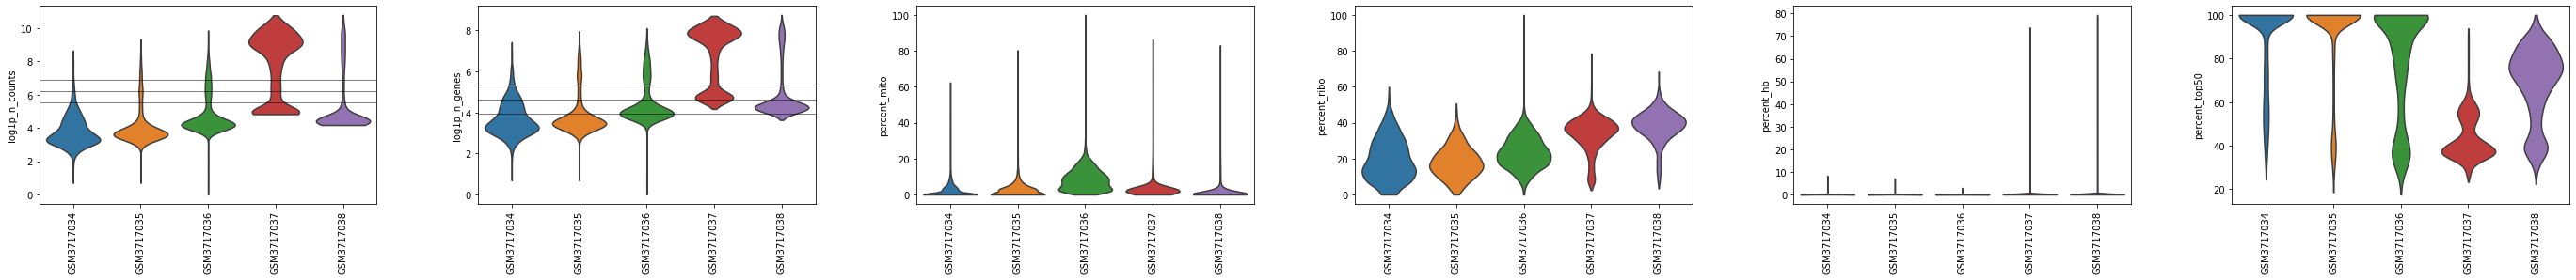

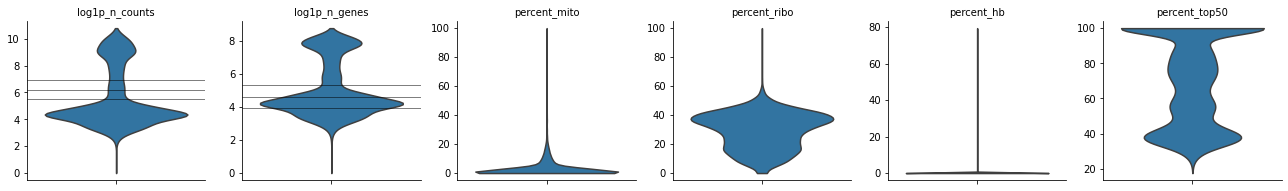

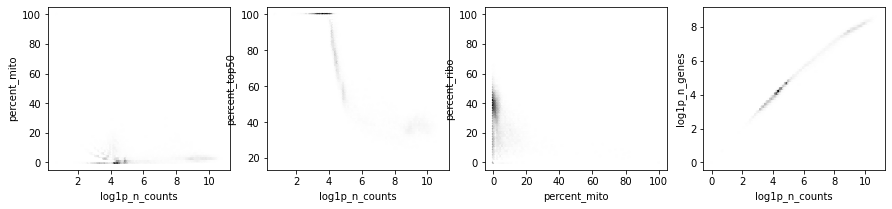

In [3]:
sk.plot_qc(raw_ad0, groupby="sample_id")

In [3]:
ad1 = raw_ad0.copy()

In [4]:
ad2 = sk.auto_filter_cells(
    ad1,
    min_count=1000,
    filter_kw={
        "metrics": ["n_counts", "n_genes", "percent_mito"],
        "min_count": 1000,
        "min_gene": 200,
        "max_mito": 20,
        "min_pass_rate": 0.1,
        "onesided": True,
    }.copy(),
)

n_counts: [917, 48451.0], 5454/20995 pass
n_genes: [195, 6347], 6606/20995 pass
percent_mito: [0, 19.203178570258476], 20466/20995 pass
5285/20995 pass


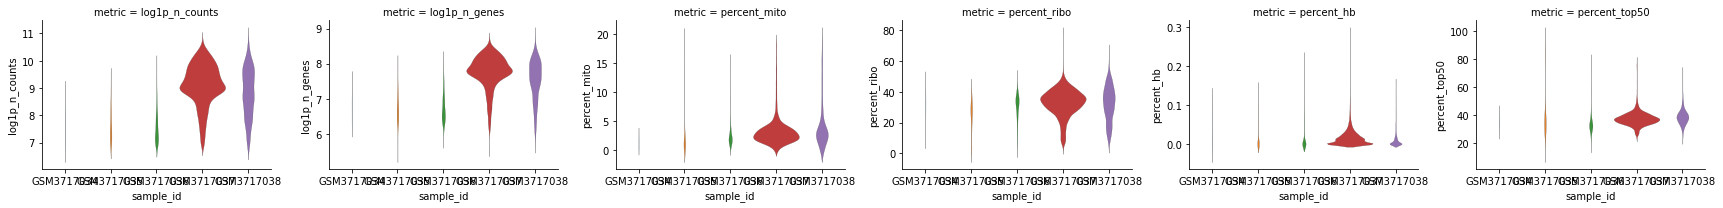

In [6]:
sk.set_figsize((4, 3))
sk.plot_qc_violin(ad2, groupby="sample_id")

In [7]:
ad2

AnnData object with n_obs × n_vars = 5285 × 38953
    obs: 'platform', 'sample_id', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50'
    var: 'mito', 'ribo', 'hb', 'n_counts', 'n_cells'
    uns: 'sample_id_colors', 'auto_filter_cells'

In [10]:
ad2.obs.platform.value_counts()

chromium    4848
dropseq      437
Name: platform, dtype: int64

In [11]:
ad2.obs.sample_id.value_counts()

GSM3717037    3839
GSM3717038    1009
GSM3717036     283
GSM3717035     140
GSM3717034      14
Name: sample_id, dtype: int64

## harmony

In [ ]:
ad3 = sk.simple_default_pipeline(
    ad2,
    post_filter_only=True,
    do_clustering=True,
    batch=["platform", "sample_id"],
    batch_method="harmony",
    zero_center=True,
    hvg_kw={"by_batch": ("platform", 1), "n_hvg": 2000},
    pca_kw={"remove_genes": ("mito", "ribo")},
)

In [57]:
ad3

AnnData object with n_obs × n_vars = 5253 × 5021
    obs: 'platform', 'sample_id', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'leiden_hm_r0_1', 'leiden_hm_r0_3', 'leiden_hm_r0_5', 'leiden_hm_r0_7', 'leiden_hm_r0_9'
    var: 'mito', 'ribo', 'hb', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std', 'hvg_full'
    uns: 'sample_id_colors', 'auto_filter_cells', 'log1p', 'hvg', 'pca', 'neighbors_hm', 'umap', 'leiden'
    obsm: 'X_pca', 'X_pca_hm', 'X_umap_hm'
    varm: 'PCs'
    obsp: 'neighbors_hm_distances', 'neighbors_hm_connectivities'

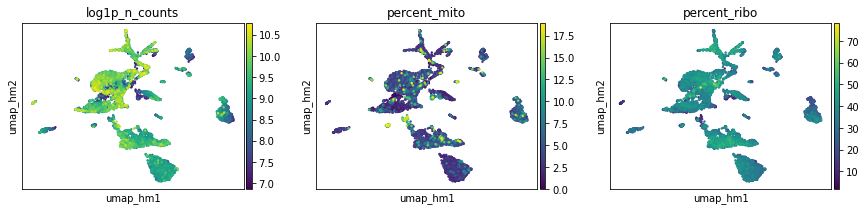

In [58]:
sc.pl.embedding(ad3, basis="umap_hm", color=["log1p_n_counts", "percent_mito", "percent_ribo"]);

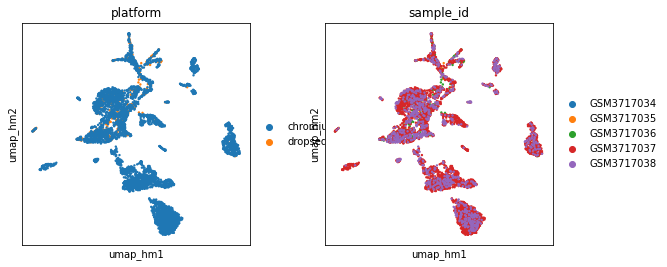

In [67]:
sc.pl.embedding(ad3, basis="umap_hm", color=["platform", "sample_id"]);

In [205]:
sc.tl.score_genes_cell_cycle(ad3, s_genes=s_genes, g2m_genes=g2m_genes, use_raw=True)

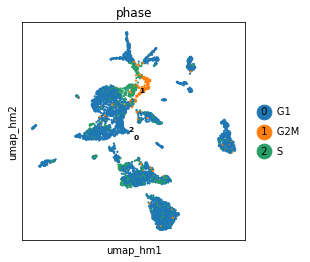

In [207]:
sk.plot_embedding(ad3, basis="umap_hm", groupby="phase", size=20);

In [59]:
sk.leiden(ad3, resolution=[0.2], use_graph="neighbors_hm", key_added="hm")

['leiden_hm_r0_2']

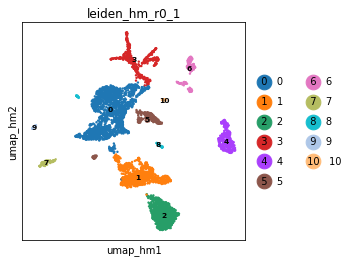

In [60]:
sk.plot_embedding(ad3, basis="umap_hm", groupby="leiden_hm_r0_1");

In [61]:
mkst_hm1 = sk.calc_marker_stats(ad3, groupby="leiden_hm_r0_1")

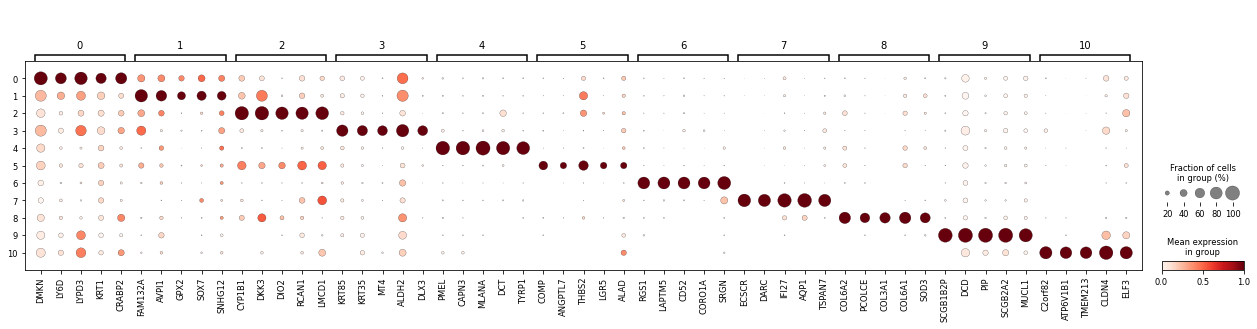

In [63]:
mks_hm1 = sk.filter_marker_stats(mkst_hm1[2], max_next_frac=0.4, min_mean_diff=0.2)
sk.plot_markers(ad3, groupby="leiden_hm_r0_1", mks=mks_hm1, standard_scale="var")

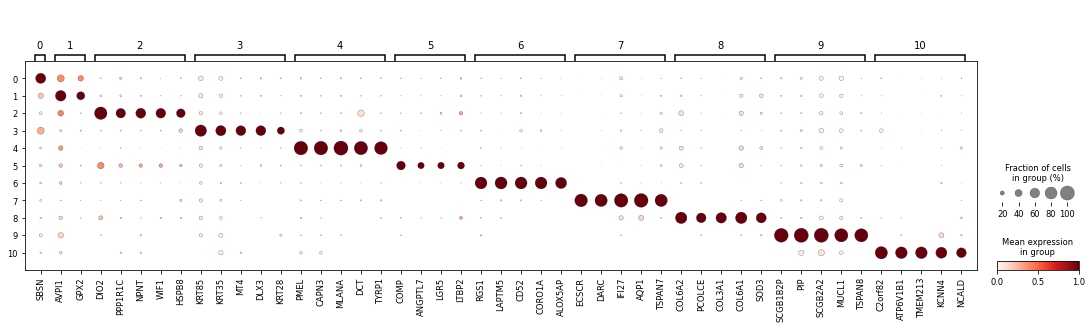

In [72]:
mks_hm1 = sk.filter_marker_stats(
    mkst_hm1[2], max_next_frac=0.4, min_mean_diff=0.1, how="and", single=True
)
sk.plot_markers(ad3, groupby="leiden_hm_r0_1", mks=mks_hm1, standard_scale="var")

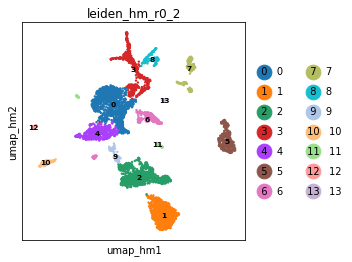

In [64]:
sk.plot_embedding(ad3, basis="umap_hm", groupby="leiden_hm_r0_2");

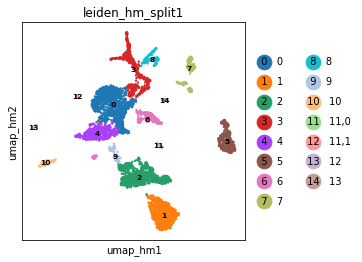

In [85]:
sk.leiden(
    ad3,
    resolution=0.1,
    use_graph="neighbors_hm",
    restrict_to=["leiden_hm_r0_2", ["11"]],
    key_added="hm_split1",
)
sk.plot_embedding(ad3, basis="umap_hm", groupby="leiden_hm_split1");

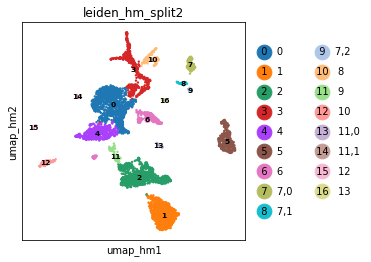

In [86]:
sk.leiden(
    ad3,
    resolution=0.1,
    use_graph="neighbors_hm",
    restrict_to=["leiden_hm_split1", ["7"]],
    key_added="hm_split2",
)
sk.plot_embedding(ad3, basis="umap_hm", groupby="leiden_hm_split2");

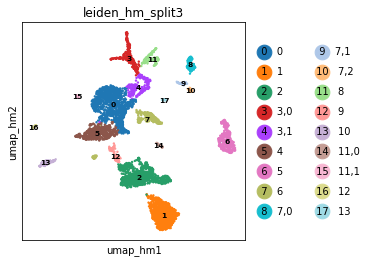

In [103]:
sk.leiden(
    ad3,
    resolution=0.05,
    use_graph="neighbors_hm",
    restrict_to=["leiden_hm_split2", ["3"]],
    key_added="hm_split3",
)
sk.plot_embedding(ad3, basis="umap_hm", groupby="leiden_hm_split3");

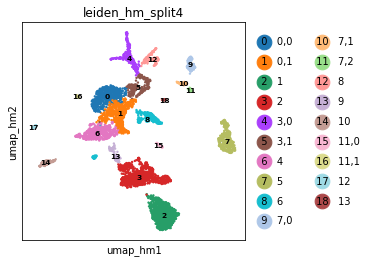

In [294]:
sk.leiden(
    ad3,
    resolution=0.07,
    use_graph="neighbors_hm",
    restrict_to=["leiden_hm_split3", ["0"]],
    key_added="hm_split4",
)
sk.plot_embedding(ad3, basis="umap_hm", groupby="leiden_hm_split4");

In [128]:
ad3.obs["leiden_hm_split5"] = sk.regroup(
    ad3, groupby="leiden_hm_split4", regroups={"2": ["2", "9"]}
)

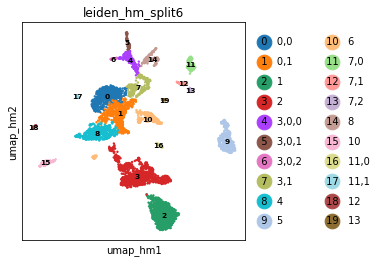

In [150]:
sk.leiden(
    ad3,
    resolution=0.1,
    use_graph="neighbors_hm",
    restrict_to=["leiden_hm_split5", ["3,0"]],
    key_added="hm_split6",
)
sk.plot_embedding(ad3, basis="umap_hm", groupby="leiden_hm_split6");

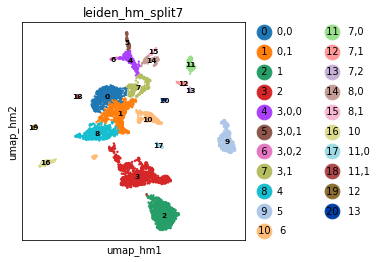

In [158]:
sk.leiden(
    ad3,
    resolution=0.1,
    use_graph="neighbors_hm",
    restrict_to=["leiden_hm_split6", ["8"]],
    key_added="hm_split7",
)
sk.plot_embedding(ad3, basis="umap_hm", groupby="leiden_hm_split7");

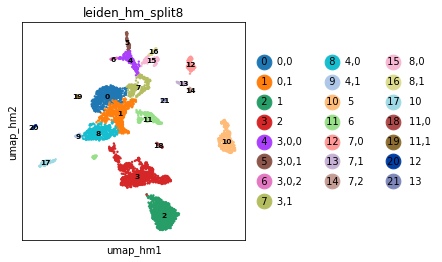

In [267]:
sk.leiden(
    ad3,
    resolution=0.13,
    use_graph="neighbors_hm",
    restrict_to=["leiden_hm_split7", ["4"]],
    key_added="hm_split8",
)
sk.plot_embedding(ad3, basis="umap_hm", groupby="leiden_hm_split8");

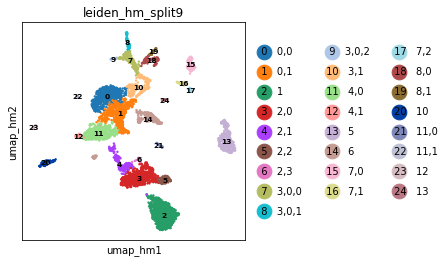

In [270]:
sk.leiden(
    ad3,
    resolution=0.1,
    use_graph="neighbors_hm",
    restrict_to=["leiden_hm_split8", ["2"]],
    key_added="hm_split9",
)
sk.plot_embedding(ad3, basis="umap_hm", groupby="leiden_hm_split9");

In [271]:
mkst_hm2 = sk.calc_marker_stats(ad3, groupby="leiden_hm_split9")

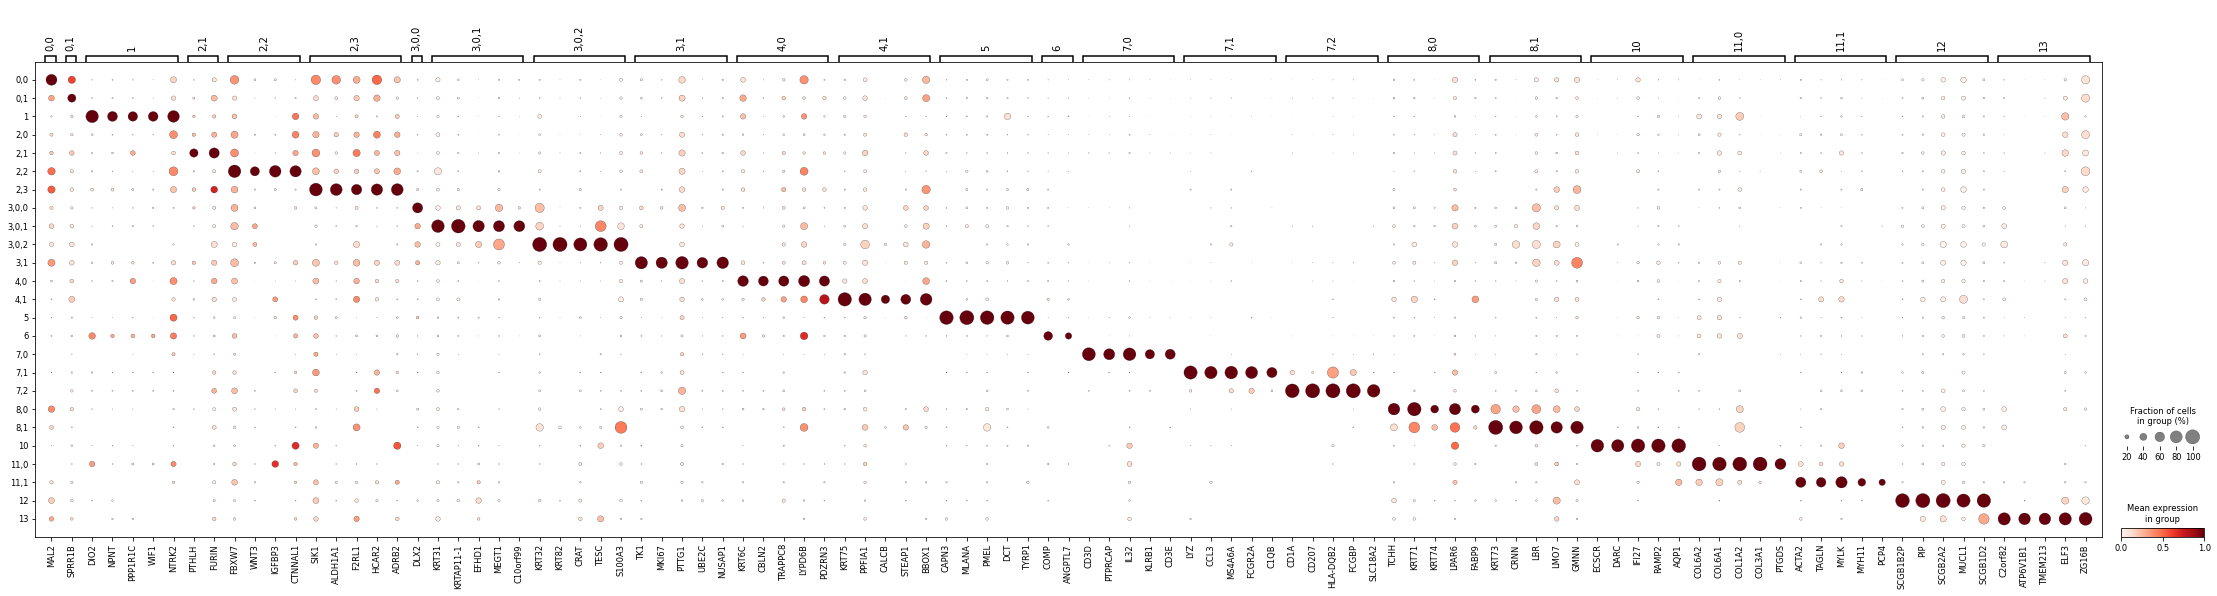

In [278]:
mks_hm2 = sk.filter_marker_stats(
    mkst_hm2[2], max_next_frac=0.5, min_mean_diff=0.15, how="and", single=False
)
sk.plot_markers(ad3, groupby="leiden_hm_split9", mks=mks_hm2, standard_scale="var")

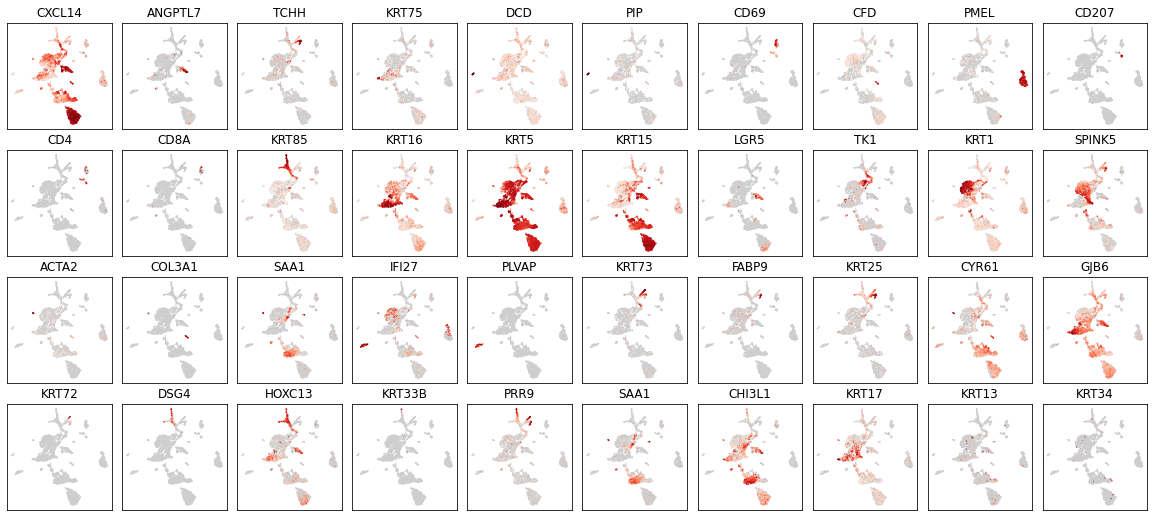

In [187]:
sk.plot_genes(
    ad3,
    basis="umap_hm",
    ncols=10,
    size=5,
    genes=[
        "CXCL14",
        "ANGPTL7",
        "TCHH",
        "KRT75",
        "DCD",
        "PIP",
        "CD69",
        "CFD",
        "PMEL",
        "CD207",
        "CD4",
        "CD8A",
        "KRT85",
        "KRT16",
        "KRT5",
        "KRT15",
        "LGR5",
        "TK1",
        "KRT1",
        "SPINK5",
        "ACTA2",
        "COL3A1",
        "SAA1",
        "IFI27",
        "PLVAP",
        "KRT73",
        "FABP9",
        "KRT25",
        "CYR61",
        "GJB6",
        "KRT72",
        "DSG4",
        "HOXC13",
        "KRT33B",
        "PRR9",
        "SAA1",
        "CHI3L1",
        "KRT17",
        "KRT13",
        "KRT34",
    ],
)

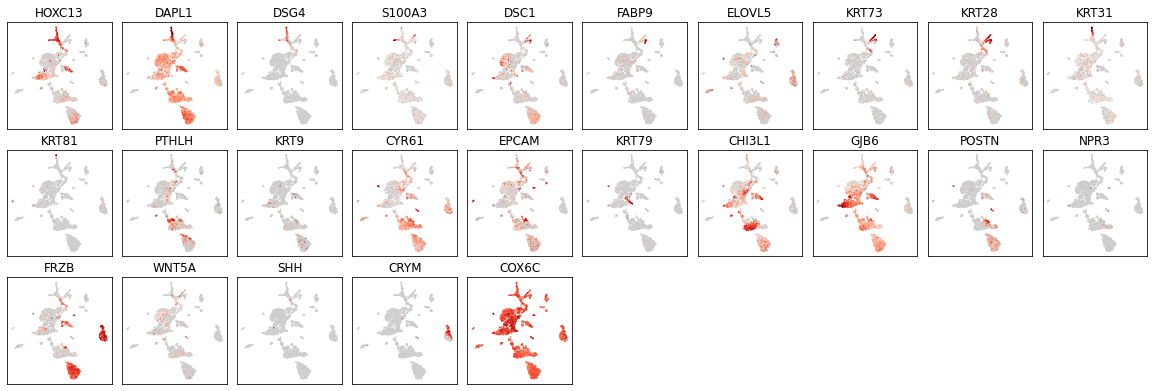

In [306]:
sk.plot_genes(
    ad3,
    basis="umap_hm",
    ncols=10,
    size=5,
    genes=[
        "HOXC13",
        "DAPL1",
        "DSG4",
        "S100A3",
        "DSC1",
        "FABP9",
        "ELOVL5",
        "KRT73",
        "KRT28",
        "KRT31",
        "KRT81",
        "PTHLH",
        "KRT9",
        "CYR61",
        "EPCAM",
        "KRT79",
        "CHI3L1",
        "GJB6",
        "POSTN",
        "NPR3",
        "FRZB",
        "WNT5A",
        "SHH",
        "CRYM",
        "COX6C",
    ],
)

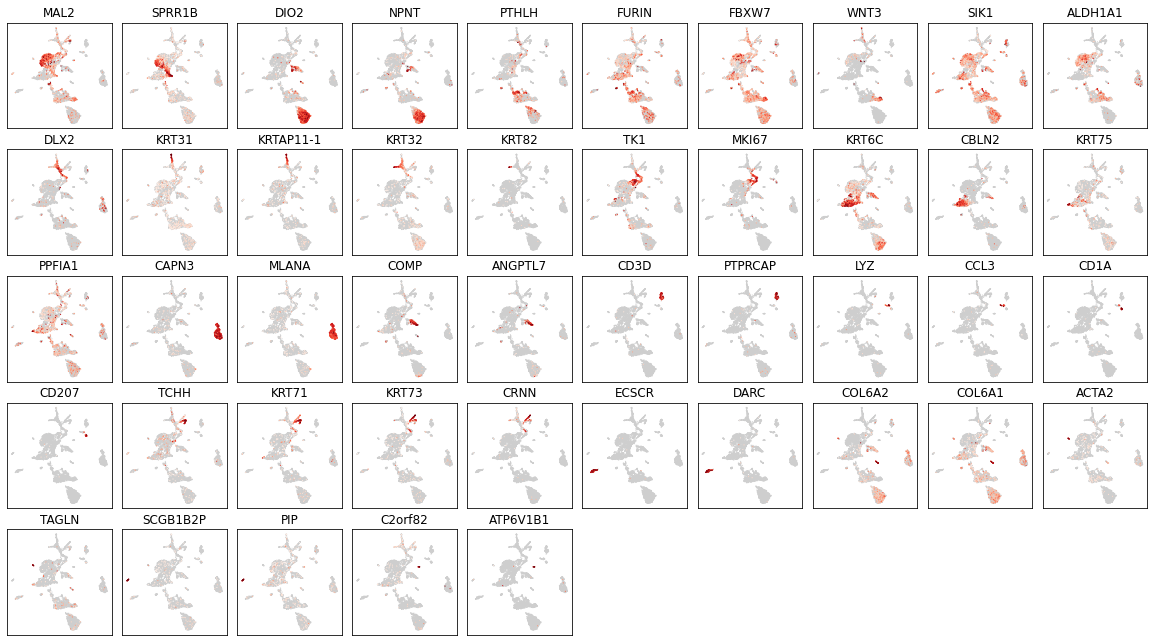

In [279]:
sk.plot_genes(
    ad3,
    basis="umap_hm",
    ncols=10,
    genes=mks_hm2.groupby("top_frac_group").head(2).index.to_list(),
    size=5,
)

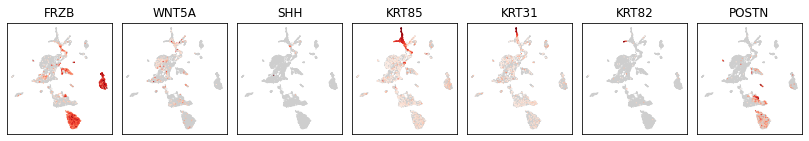

In [242]:
sk.plot_genes(
    ad3,
    basis="umap_hm",
    genes=["FRZB", "WNT5A", "SHH", "KRT85", "KRT31", "KRT82", "POSTN"],
    figsize=(2, 2),
    size=5,
)

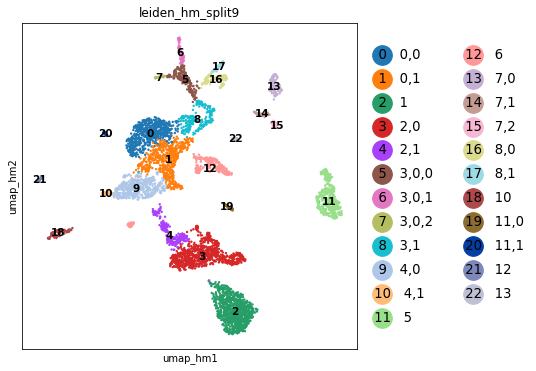

In [262]:
sk.plot_embedding(
    ad3, basis="umap_hm", groupby="leiden_hm_split9", legend_fontsize=12, figsize=(6, 6)
);

In [173]:
mks_hm2[mks_hm2.top_frac_group == "13"].head(10)

top_frac_group  top_frac  frac_diff  max_frac_diff top_mean_group  \
C2orf82              13  0.833333   0.452381       0.586758             13   
ATP6V1B1             13  0.777778   0.727778       0.749206             13   
TMEM213              13  0.777778   0.765730       0.767379             13   
ELF3                 13  0.833333   0.414152       0.433333             13   
ZG16B                13  0.888889   0.407222       0.417485             13   
KCNN4                13  0.722222   0.465079       0.560060             13   
NCALD                13  0.611111   0.514426       0.532164             13   
ACTR3B               13  0.722222   0.531746       0.612633             13   
SLC13A2              13  0.611111   0.611111       0.611111             13   
CA6                  13  0.611111   0.505392       0.565019             13   

          top_mean  mean_diff  max_mean_diff  
C2orf82   0.691210   0.644004       0.660570  
ATP6V1B1  0.559871   0.553947       0.554774  
TMEM213   0.509437   0.505645       0.507395  
ELF3      0.608108   0.464583       0.504648  
ZG16B     0.519442   0.447039       0.456631  
KCNN4     0.516410   0.445087       0.446719  
NCALD     0.476709   0.441512       0.446560  
ACTR3B    0.428898   0.397470       0.397836  
SLC13A2   0.389605   0.389605       0.389605  
CA6       0.403754   0.372884       0.393254

In [242]:
ad3.obs["annot"] = sk.regroup(
    ad3,
    groupby="leiden_hm_split8",
    regroups={
        "Basal": "2",
        "Bulge": "1",
        "Lower bulge": "6",
        "IRS cuticle": "8,1",
        "IRS H/H": "8,0",
        "ORS": "4,0",
        "CL": "4,1",
        "Matrix": "3,0,0",
        "Medulla": "3,0,1",
        "Cortex": "3,0,2",
        "IFE basal": "3,1",
        "IFE spinous": "0,0",
        "IFE granular": "0,1",
        "Melanocyte": "5",
        "Dermal papilae/sheath": "11,0",
        "SM": "11,1",
        "Sebaceous": "12",
        "VE": "10",
        "T": "7,0",
        "Macrophage": "7,1",
        "LC": "7,2",
        "Unknown": "13",
    },
)

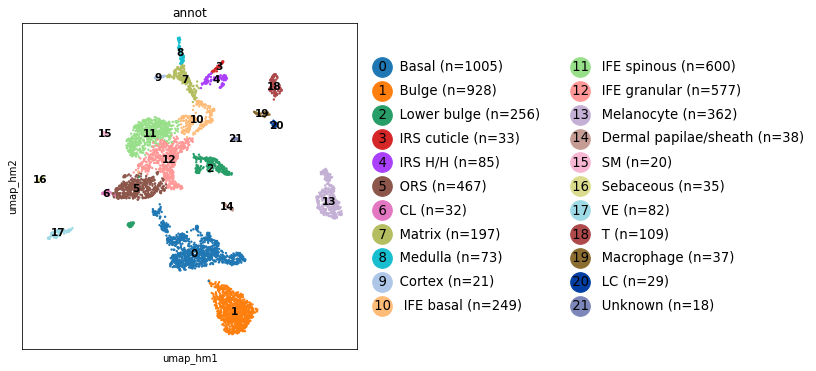

In [243]:
sk.plot_embedding(
    ad3, basis="umap_hm", groupby="annot", legend_fontsize=12, figsize=(6, 6), annot="full"
);

In [248]:
mkst_hm3 = sk.calc_marker_stats(ad3, groupby="annot")

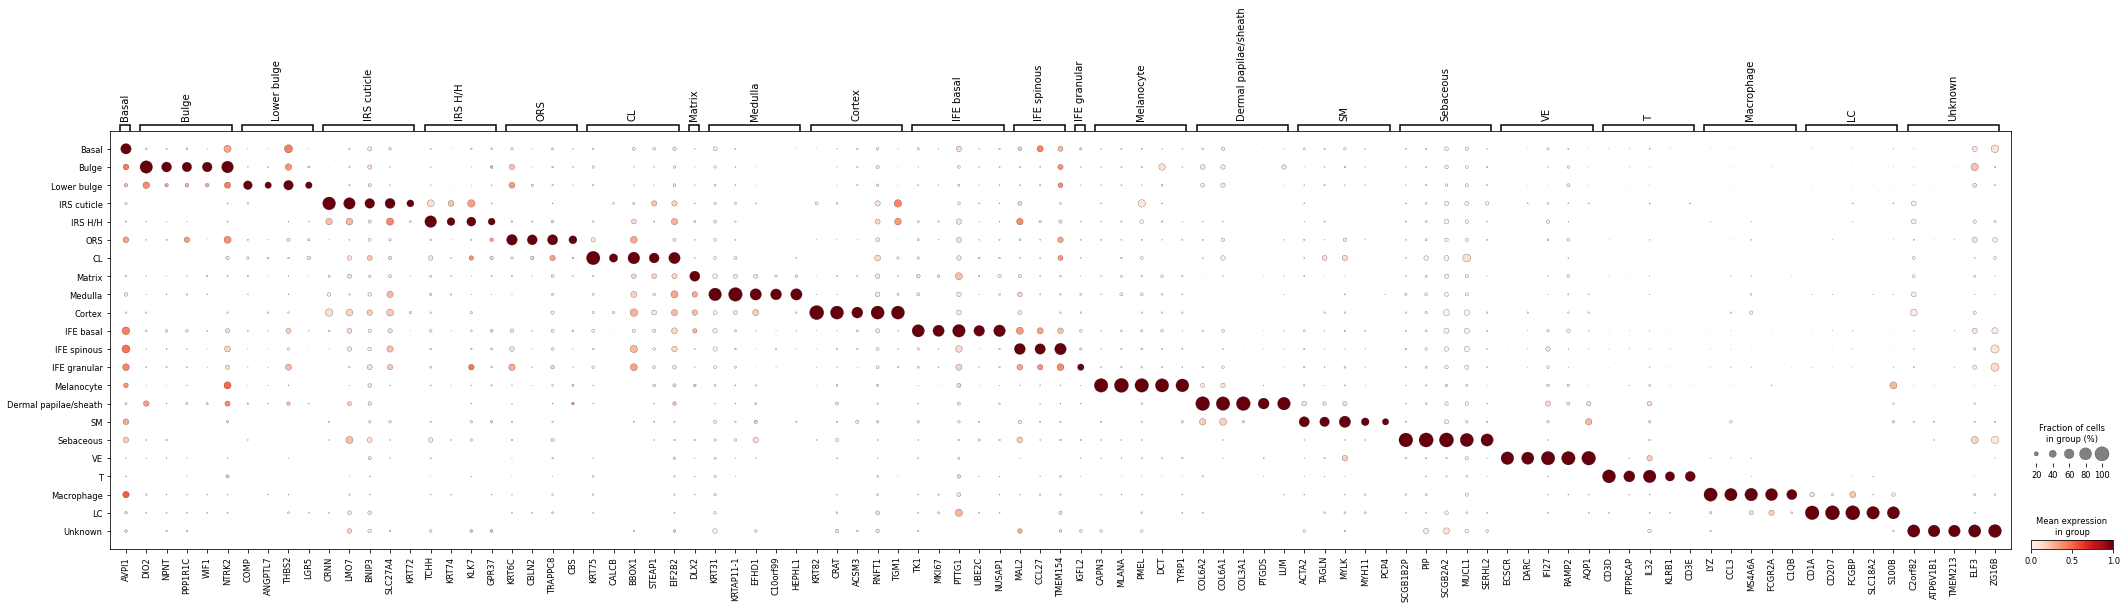

In [250]:
mks_hm3 = sk.filter_marker_stats(
    mkst_hm3[2], max_next_frac=0.5, min_mean_diff=0.1, how="and", single=True
)
sk.plot_markers(ad3, groupby="annot", mks=mks_hm3, standard_scale="var")

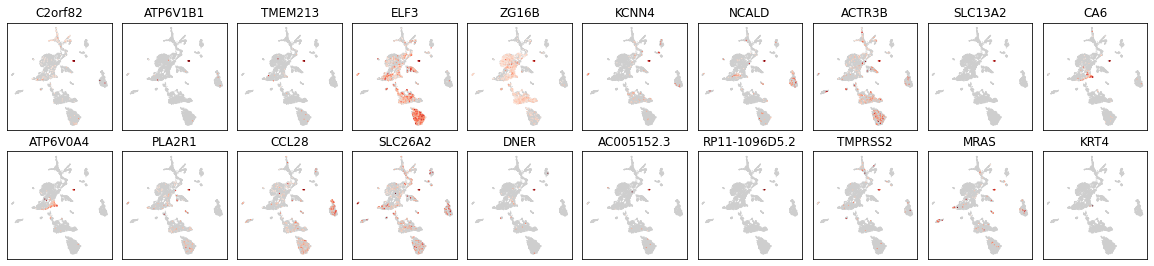

In [231]:
sk.plot_genes(
    ad3,
    basis="umap_hm",
    ncols=10,
    genes=mks_hm2[mks_hm2.top_frac_group == "13"].head(19).index.to_list() + ["KRT4"],
    size=5,
)

In [219]:
",".join(mks_hm2[mks_hm2.top_frac_group == "13"].head(20).index.to_list())

'C2orf82,ATP6V1B1,TMEM213,ELF3,ZG16B,KCNN4,NCALD,ACTR3B,SLC13A2,CA6,ATP6V0A4,PLA2R1,CCL28,SLC26A2,DNER,AC005152.3,RP11-1096D5.2,TMPRSS2,MRAS,C10orf10'

In [220]:
",".join(mks_hm2[mks_hm2.top_frac_group == "12"].head(20).index.to_list())

'SCGB1B2P,PIP,SCGB2A2,MUCL1,SERHL2,TSPAN8,PLA2G2A,OBP2B,SCGB2A1,SCGB2B2,HMGCS2,OBP2A,SCGB1D1,CEACAM6,U3,CREB3L4,FOXA1,AZGP1P1,CEACAM5,C9orf152'

In [221]:
",".join(mks_hm2[mks_hm2.top_frac_group == "0,0"].head(20).index.to_list())

'MAL2,CCL27,TMEM154,CHP2'

In [222]:
",".join(mks_hm2[mks_hm2.top_frac_group == "0,1"].head(20).index.to_list())

'IGFL2'

In [244]:
",".join(mks_hm2[mks_hm2.top_frac_group == "4,0"].head(20).index.to_list())

'KRT6C,CBLN2,TRAPPC8,CBS'

In [245]:
",".join(mks_hm2[mks_hm2.top_frac_group == "4,1"].head(20).index.to_list())

'KRT75,CALCB,BBOX1,STEAP1,EIF2B2,SHOC2,EMB,ANXA2P2,SVIP,SMOC1,LIPG,AC098614.1,MLLT11,NT5C3A,CARD16,KRTAP17-1,SLC5A6,MYL12AP1,TMSB4XP6,STAT1'

In [224]:
",".join(mks_hm2[mks_hm2.top_frac_group == "6"].head(20).index.to_list())

'COMP,ANGPTL7,THBS2,LGR5'

In [225]:
",".join(mks_hm2[mks_hm2.top_frac_group == "8,1"].head(20).index.to_list())

'CRNN,LMO7,BNIP3,SLC27A4,KRT72,RASL11B,SLC8A3,PAQR5,ENC1,NOTCH2NL,SLN,FAM89A,ST6GALNAC3,CCDC102A,GAS2L3,FZD10,EVPL,DOK4,EPS8,SLC52A3'

# Train model

In [246]:
ad3S = sk.subsample(ad3, fraction=1, groupby="annot", min_n=100, max_n=100)

In [247]:
lr = sk.LR_train(ad3S, groupby="annot", use_rep="raw", max_pass=40, save="rie20_lognorm.pkl")

# Save object

In [197]:
sk.clear_colors(ad3)

In [198]:
ad3.write("rie20.harmony.processed.h5ad", compression="lzf")

# Integrate

In [2]:
ad3 = sc.read("rie20.harmony.processed.h5ad")

Only considering the two last: ['.processed', '.h5ad'].
Only considering the two last: ['.processed', '.h5ad'].


In [3]:
ad3

AnnData object with n_obs × n_vars = 5253 × 5021
    obs: 'platform', 'sample_id', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'leiden_hm_r0_1', 'leiden_hm_r0_3', 'leiden_hm_r0_5', 'leiden_hm_r0_7', 'leiden_hm_r0_9', 'leiden_hm_r0_2', 'leiden_hm_split1', 'leiden_hm_split2', 'leiden_hm_split3', 'leiden_hm_split4', 'leiden_hm_split5', 'leiden_hm_split6', 'leiden_hm_split7', 'annot'
    var: 'mito', 'ribo', 'hb', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std', 'hvg_full'
    uns: 'auto_filter_cells', 'hvg', 'leiden', 'neighbors_hm', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_hm', 'X_umap_hm'
    varm: 'PCs'
    obsp: 'neighbors_hm_connectivities', 'neighbors_hm_distances'

In [4]:
sc.tl.leiden(
    ad3,
    resolution=0.13,
    restrict_to=("annot", ["ORS"]),
    neighbors_key="neighbors_hm",
    key_added="nh3_annot1",
)

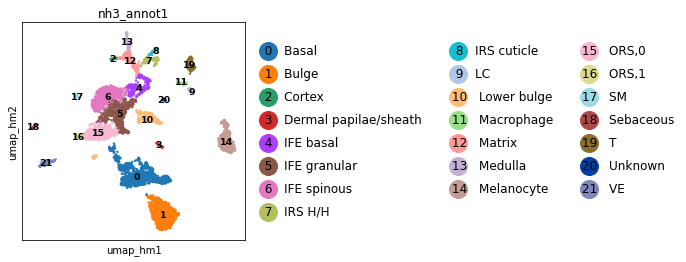

In [138]:
sk.plot_embedding(ad3, basis="umap_hm", groupby="nh3_annot1");

In [5]:
ad3.obs["nh3_annot2"] = sk.regroup(
    ad3,
    groupby="nh3_annot1",
    regroups={
        "ORS": "ORS,0",
        "CL": "ORS,1",
    },
)

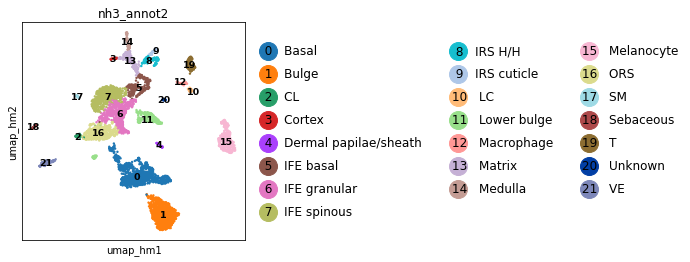

In [6]:
sk.plot_embedding(ad3, basis="umap_hm", groupby="nh3_annot2");

In [7]:
ad3S = sk.subsample(ad3, fraction=1, groupby="nh3_annot2", min_n=100, max_n=100)

In [143]:
ad3.obs.nh3_annot2.value_counts()

Basal                    1005
Bulge                     928
IFE spinous               600
IFE granular              577
ORS                       467
Melanocyte                362
Lower bulge               256
IFE basal                 249
Matrix                    197
T                         109
IRS H/H                    85
VE                         82
Medulla                    73
Dermal papilae/sheath      38
Macrophage                 37
Sebaceous                  35
IRS cuticle                33
CL                         32
LC                         29
Cortex                     21
SM                         20
Unknown                    18
Name: nh3_annot2, dtype: int64

In [8]:
fsk_ad = sc.read("../20210611_final_object/fetal_skin.norm.maternal_removed.20220202.h5ad")

Only considering the two last: ['.20220202', '.h5ad'].
Only considering the two last: ['.20220202', '.h5ad'].


In [9]:
sk.LR_predict(fsk_ad, "rie20_lognorm.pkl", use_rep="X", key_added="rie20_annot", min_prob=0)

26860 features used for prediction


In [10]:
sk.LR_predict(fsk_ad, "rie20_lognorm.pkl", use_rep="X", key_added="rie20_annot50", min_prob=0.5)

26860 features used for prediction


In [149]:
fsk_ad

AnnData object with n_obs × n_vars = 186533 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'joint_annotation_20220202', 'independent_annotation_refined_20220202', 'fig1b_annotation_20220202', 'rie20_annot', 'rie20_an

In [330]:
fsk_ad.obs.joint_annotation.cat.categories

Index(['ASDC', 'Activated mac', 'Adipocytes', 'Arterial', 'B cell', 'Basal',
       'Basal POSTN+', 'Basal SHH+', 'CD4 T cell', 'CD8 T cell',
       'Capillary (venular tip)', 'Capillary/postcapillary venule',
       'Companion layer', 'Cuticle/cortex', 'DC1', 'DC2', 'Dermal condensate',
       'Dermal papillia', 'Early LE', 'Early endothelial cell',
       'Early erythroid', 'Early erythroid (embryonic)',
       'Early fibroblast FRZB+', 'Early fibroblast HOXC5+', 'Early myocytes',
       'Eo/baso/mast cell progenitor', 'Erythroid (embryonic)',
       'Erythroid (fetal)', 'Fibroblast WNT2+', 'Fibroblasts unknown', 'HSC',
       'ILC2', 'ILC3', 'Immature basal', 'Immature suprabasal',
       'Inflammatory DC', 'Inner root sheath', 'LC', 'LE', 'LTi',
       'Lymphoid progenitor', 'MEMP - Early erythroid', 'MEMP - Megak',
       'Mac-mono', 'Macrophage1', 'Macrophage2', 'Mast cell (earliest)',
       'Mast cell (medium)', 'Mast cell (most mature)', 'Megakaryocyte',
       'Melanoblast', 

In [11]:
fsk_adS = sk.subsample(fsk_ad, fraction=1, groupby="joint_annotation_20220202", min_n=50, max_n=100)

In [12]:
pooled_ad1 = sk.integrate(
    [fsk_adS, ad3S],
    ad_prefices=["fetal", "adult"],
    annotations=["joint_annotation_20220202", "nh3_annot2"],
    batches=["donor", "sample_id"],
    join="outer",
    pool_only=True,
)

raw_norm
raw_norm


In [445]:
pooled_ad1.obs.annot.astype("category").cat.categories.values

array(['adult_Basal', 'adult_Bulge', 'adult_CL', 'adult_Cortex', 'adult_Dermal papilae/sheath', 'adult_IFE basal', 'adult_IFE granular',
       'adult_IFE spinous', 'adult_IRS H/H', 'adult_IRS cuticle', 'adult_LC', 'adult_Lower bulge', 'adult_Macrophage', 'adult_Matrix',
       'adult_Medulla', 'adult_Melanocyte', 'adult_ORS', 'adult_SM', 'adult_Sebaceous', 'adult_T', 'adult_Unknown', 'adult_VE', 'fetal_ASDC',
       'fetal_Activated mac', 'fetal_Adipocytes', 'fetal_Arterial', 'fetal_B cell', 'fetal_Basal', 'fetal_Basal POSTN+', 'fetal_Basal SHH+',
       'fetal_CD4 T cell', 'fetal_CD8 T cell', 'fetal_Capillary (venular tip)', 'fetal_Capillary/postcapillary venule', 'fetal_Companion layer',
       'fetal_Cuticle/cortex', 'fetal_DC1', 'fetal_DC2', 'fetal_Dermal condensate', 'fetal_Dermal papillia', 'fetal_Early LE',
       'fetal_Early endothelial cell', 'fetal_Early erythroid', 'fetal_Early erythroid (embryonic)', 'fetal_Early fibroblast FRZB+',
       'fetal_Early fibroblast HOXC5+', 

In [152]:
pooled_ad1a = sk.simple_default_pipeline(
    pooled_ad1,
    post_norm_only=True,
    do_clustering=False,
    batch="batch",
    batch_method="harmony",
    hvg_kw={"by_batch": ("batch", 1), "n_hvg": 2000},
    pca_kw={"remove_genes": ("mito", "ribo")},
)

... storing 'sanger_id' as categorical
... storing 'chemistry' as categorical
... storing 'batch' as categorical
... storing 'gender' as categorical
... storing 'sorting' as categorical
... storing 'sample' as categorical
... storing 'chemistry_sorting' as categorical
... storing 'cell_caller' as categorical
... storing 'independent_annotation_refined' as categorical
... storing 'independent_annotation_broad1' as categorical
... storing 'independent_annotation_broad2' as categorical
... storing 'independent_annotation_broad3' as categorical
... storing 'independent_annotation_broad4' as categorical
... storing 'independent_annotation_broad5' as categorical
... storing 'joint_annotation' as categorical
... storing 'is_maternal' as categorical
... storing 'fig1b_annotation' as categorical
... storing 'independent_annotation_refined_20220201a' as categorical
... storing 'independent_annotation_refined_20220201b' as categorical
... storing 'independent_annotation_broad1_20220201' as catego

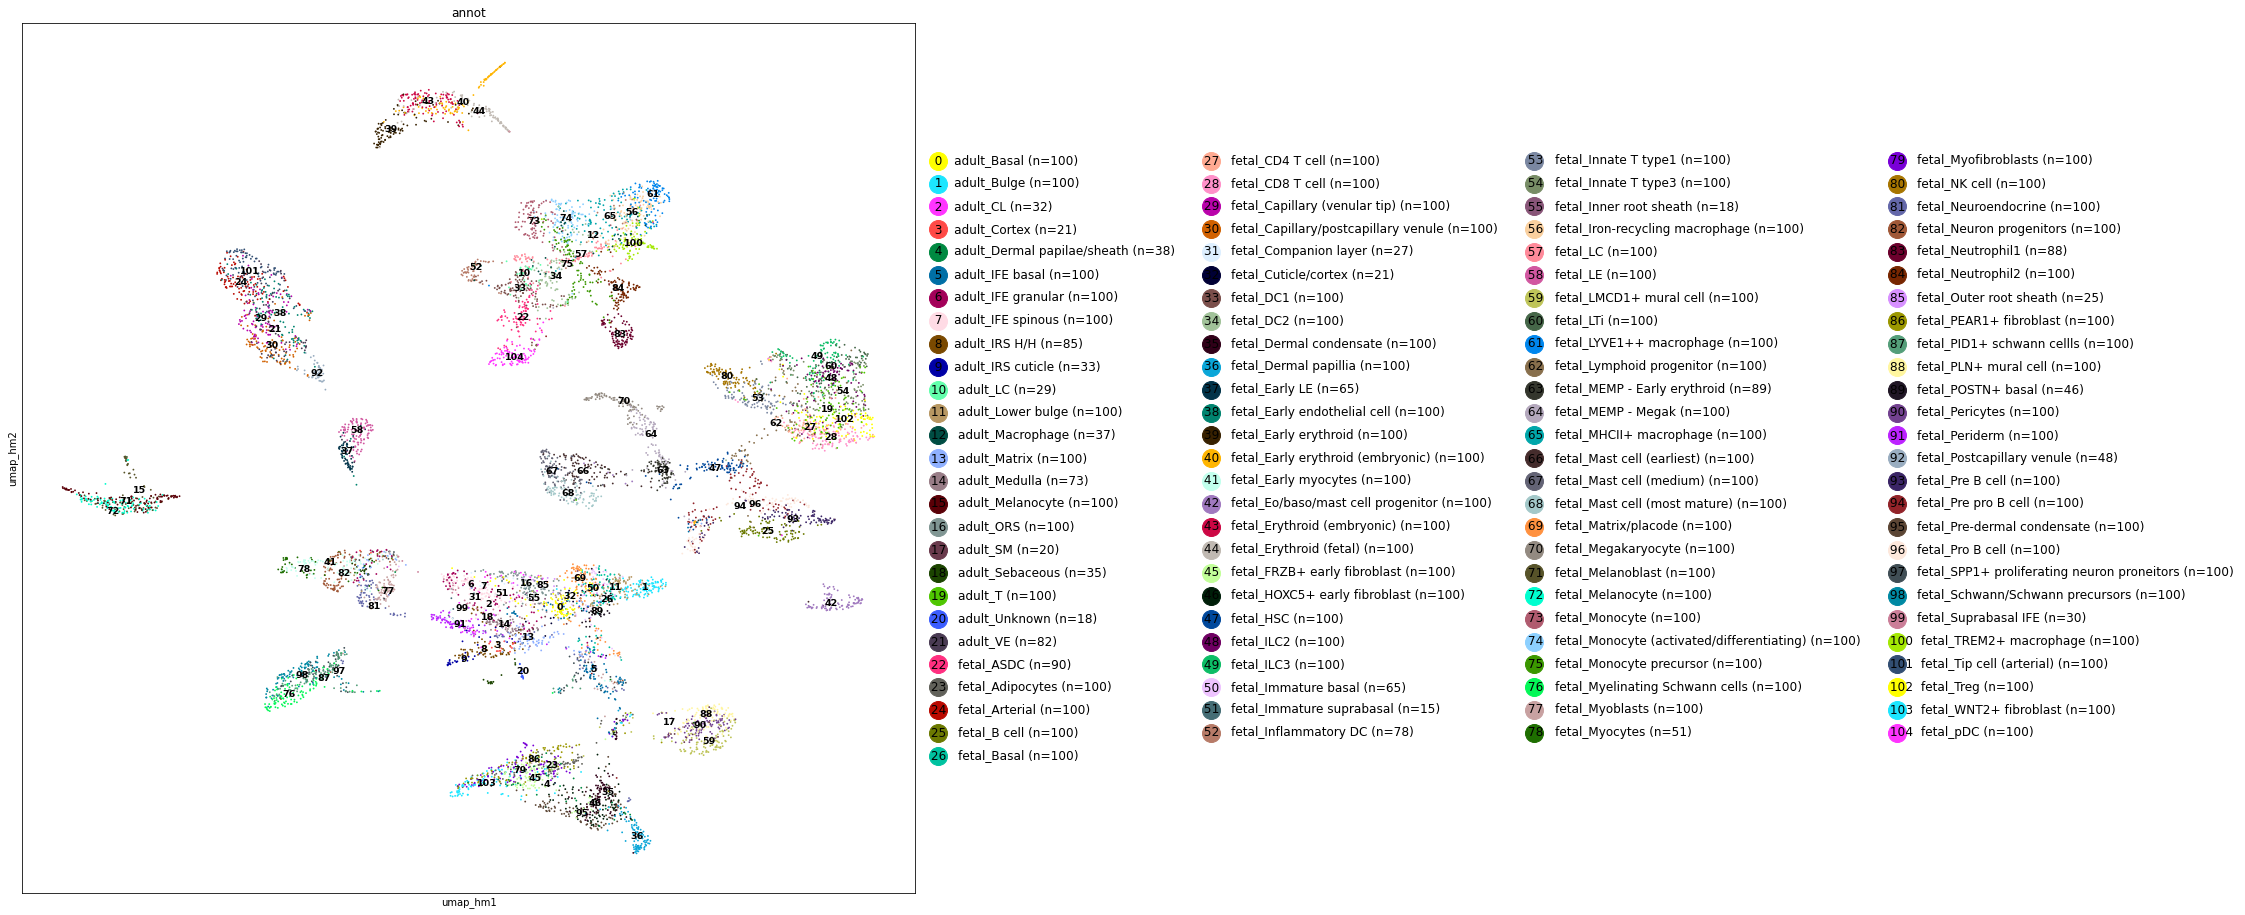

In [154]:
sk.clear_colors(pooled_ad1a)
sk.plot_embedding(
    pooled_ad1a,
    basis="umap_hm",
    groupby="annot",
    annot="full",
    figsize=(16, 16),
    legend_fontsize=11,
);

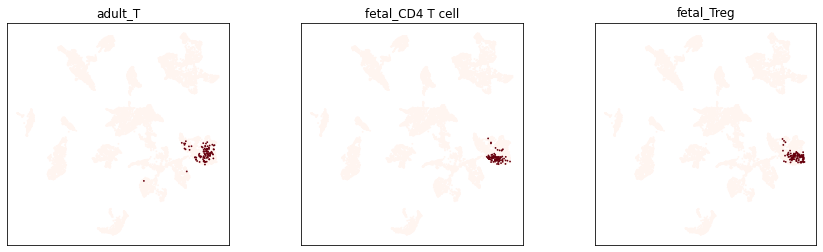

In [464]:
sk.highlight(
    pooled_ad1a,
    basis="umap_hm",
    groupby="annot",
    groups=["adult_T", "fetal_CD4 T cell", "fetal_Treg"],
);

In [365]:
pooled_ad1a.obs.independent_annotation_broad5.cat.categories

Index(['Epithelium', 'Erythroid', 'Immune', 'Stroma', 'nan'], dtype='object')

Trying to set attribute `.uns` of view, copying.


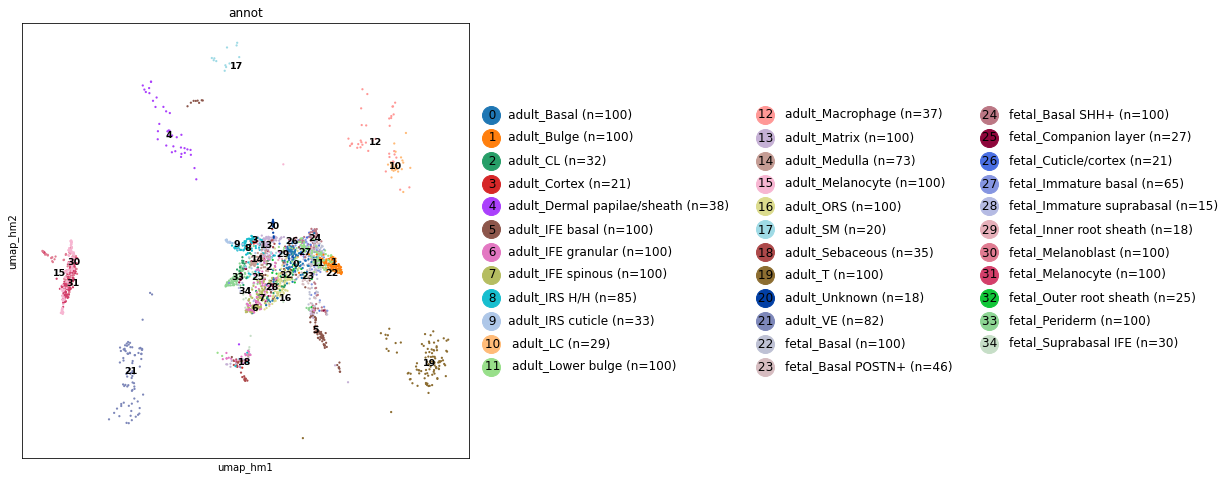

In [ ]:
sk.plot_embedding(
    pooled_ad1a[pooled_ad1a.obs.independent_annotation_broad5.isin(["Epithelium" "nan"])],
    basis="umap_hm",
    groupby="annot",
    annot="full",
    figsize=(8, 8),
    legend_fontsize=11,
    size=20,
);

In [ ]:
pooled_ad1a.obs.independent_annotation_broad4.cat.categories

Index(['Antigen Presenting Cells', 'Endothelium', 'Epithelium', 'Erythroid',
       'Lymphocytes', 'Mesenchymal cells', 'Muscle', 'Neuronal cells',
       'Other blood cells', 'nan'],
      dtype='object')

Trying to set attribute `.uns` of view, copying.


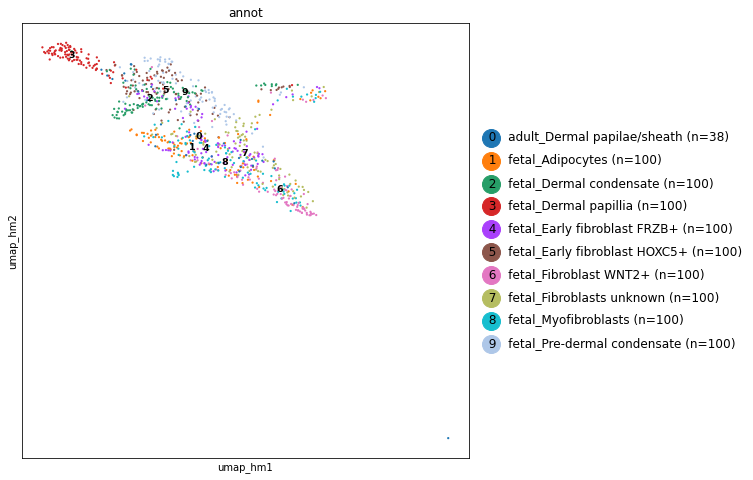

In [ ]:
sk.plot_embedding(
    pooled_ad1a[
        (pooled_ad1a.obs.independent_annotation_broad4 == "Mesenchymal cells")
        | (pooled_ad1a.obs.annot.str.startswith("adult_Dermal"))
    ],
    basis="umap_hm",
    groupby="annot",
    annot="full",
    figsize=(8, 8),
    legend_fontsize=11,
    size=20,
);

## fibroblast

In [13]:
pooled_ad1b = pooled_ad1[
    (pooled_ad1.obs.independent_annotation_broad4 == "Mesenchymal cells")
    | (pooled_ad1.obs.annot.str.startswith("adult_Dermal"))
].copy()

In [14]:
pooled_ad1b = pooled_ad1b[
    pooled_ad1b.obs.batch.isin(sk._pipeline.get_good_sized_batch(pooled_ad1b.obs.batch, min_size=5))
].copy()

In [15]:
pooled_ad1c = sk.simple_default_pipeline(
    pooled_ad1b,
    post_filter_only=True,
    do_clustering=False,
    batch="batch",
    batch_method="harmony",
    hvg_kw={"by_batch": ("batch", 1), "n_hvg": 2000},
    pca_kw={"remove_genes": ("mito", "ribo")},
)

... storing 'sanger_id' as categorical
... storing 'chemistry' as categorical
... storing 'batch' as categorical
... storing 'gender' as categorical
... storing 'sorting' as categorical
... storing 'sample' as categorical
... storing 'chemistry_sorting' as categorical
... storing 'cell_caller' as categorical
... storing 'independent_annotation_refined' as categorical
... storing 'independent_annotation_broad1' as categorical
... storing 'independent_annotation_broad2' as categorical
... storing 'independent_annotation_broad3' as categorical
... storing 'independent_annotation_broad4' as categorical
... storing 'independent_annotation_broad5' as categorical
... storing 'joint_annotation' as categorical
... storing 'is_maternal' as categorical
... storing 'fig1b_annotation' as categorical
... storing 'independent_annotation_refined_20220201a' as categorical
... storing 'independent_annotation_refined_20220201b' as categorical
... storing 'independent_annotation_broad1_20220201' as catego

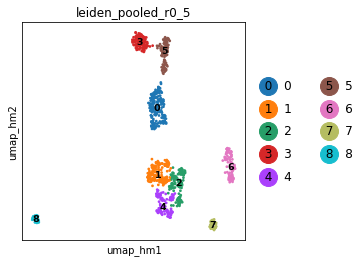

In [167]:
sk.plot_embedding(
    pooled_ad1c,
    basis="umap_hm",
    groupby="leiden_pooled_r0_5",
    size=30,
    wspace=0.7,
);

In [166]:
sk.leiden(pooled_ad1c, use_graph="neighbors_hm", resolution=0.5, key_added="pooled_r0_5")

['leiden_pooled_r0_5']

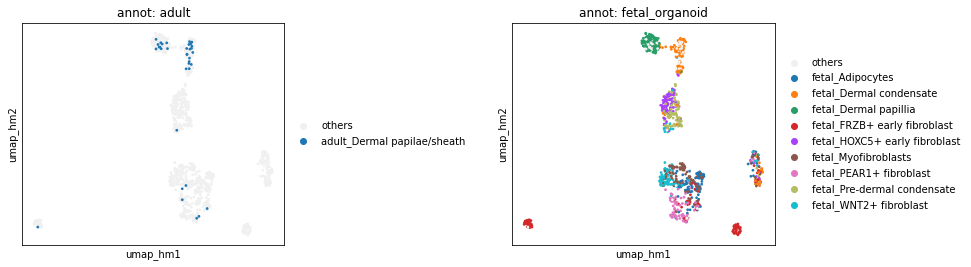

In [164]:
sk.highlight(
    pooled_ad1c,
    basis="umap_hm",
    groupby="annot",
    prefix_dict={"adult": "adult_", "fetal_organoid": "fetal_"},
    size=30,
    wspace=0.7,
);

In [196]:
"SOD3" in pooled_ad1c.var_names

True

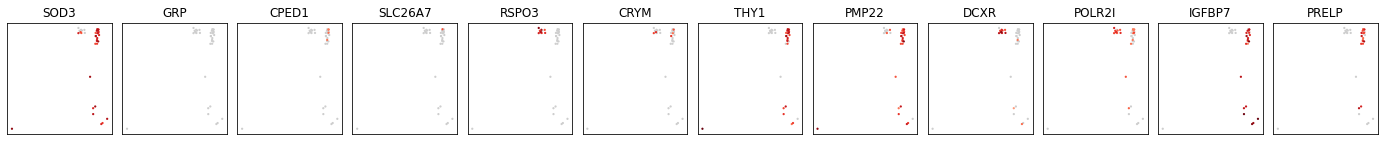

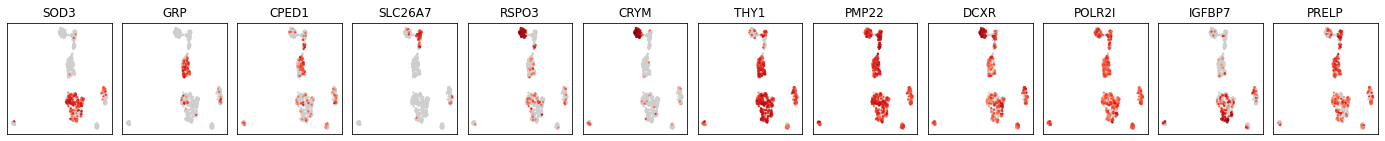

In [255]:
sk.plot_genes(
    pooled_ad1c[pooled_ad1c.obs.dataset == "adult"],
    basis="umap_hm",
    genes=[
        "SOD3",
        "GRP",
        "CPED1",
        "SLC26A7",
        "RSPO3",
        "CRYM",
        "THY1",
        "PMP22",
        "DCXR",
        "POLR2I",
        "IGFBP7",
        "PRELP",
    ],
    size=20,
    vmin=0,
    vmax=3,
)

sk.plot_genes(
    pooled_ad1c[pooled_ad1c.obs.dataset == "fetal"],
    basis="umap_hm",
    genes=[
        "SOD3",
        "GRP",
        "CPED1",
        "SLC26A7",
        "RSPO3",
        "CRYM",
        "THY1",
        "PMP22",
        "DCXR",
        "POLR2I",
        "IGFBP7",
        "PRELP",
    ],
    size=20,
    vmin=0,
    vmax=3,
);

In [244]:
sk.LR_predict(
    pooled_ad1c,
    "../20210611_final_object/fetal_skin.independent_annotation_refined_20220202.lognorm.pkl",
    key_added="fetal_pred",
)

28885 features used for prediction


Trying to set attribute `.uns` of view, copying.


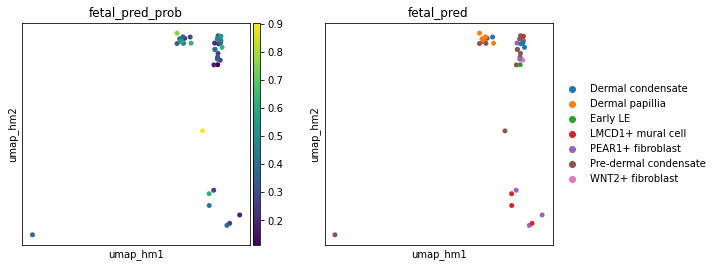

In [219]:
sc.pl.embedding(
    pooled_ad1c[pooled_ad1c.obs.dataset == "adult"],
    basis="umap_hm",
    color=["fetal_pred_prob", "fetal_pred"],
    size=100,
);

Trying to set attribute `.uns` of view, copying.


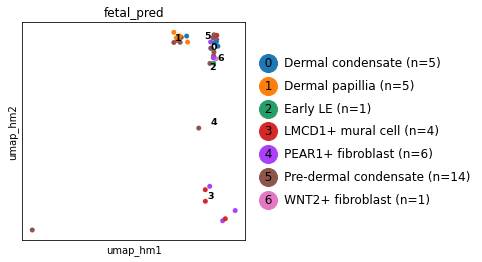

In [216]:
sk.plot_embedding(
    pooled_ad1c[pooled_ad1c.obs.dataset == "adult"],
    basis="umap_hm",
    groupby="fetal_pred",
    size=100,
    annot="full",
);

In [168]:
ad_fibro_degs = sk.diffexp_paired(
    pooled_ad1c[
        (pooled_ad1c.obs.dataset == "adult")
        & (pooled_ad1c.obs.leiden_pooled_r0_5.isin(["3", "5"])),
    ],
    groupby="leiden_pooled_r0_5",
    pair=["3", "5"],
    method="wilcoxon",
);

Trying to set attribute `.uns` of view, copying.


In [229]:
ad_fibro_deg0 = ad_fibro_degs[0].loc[
    lambda x: ~(
        x.genes.str.startswith("MT-")
        | x.genes.str.startswith("RPS")
        | x.genes.str.startswith("RPL")
    )
]

In [230]:
ad_fibro_deg1 = ad_fibro_degs[1].loc[
    lambda x: ~(
        x.genes.str.startswith("MT-")
        | x.genes.str.startswith("RPS")
        | x.genes.str.startswith("RPL")
    )
]

In [235]:
ad_fibro_deg0["Differential expression"] = ""
ad_fibro_deg0.loc[
    lambda x: (x.logfoldchanges > 1) & (x.pvals_adj < 0.5), "Differential expression"
] = "Up in dermal papillia"
ad_fibro_deg0.loc[
    lambda x: (x.logfoldchanges < -1) & (x.pvals_adj < 0.5), "Differential expression"
] = "Up in dermal condensate"

In [247]:
top_de_genes = (
    ad_fibro_deg0.loc[lambda x: (x.logfoldchanges > 3) & (x.pvals_adj < 0.6)]
    .head(10)
    .genes.to_list()
    + ad_fibro_deg1.loc[lambda x: (x.logfoldchanges > 3) & (x.pvals_adj < 0.6)]
    .head(10)
    .genes.to_list()
)

In [75]:
from adjustText import adjust_text

In [238]:
ad_fibro_deg0

cluster ref   rank     genes    scores  logfoldchanges     pvals  \
10          3   5     10     RSPO3  3.883653       32.558201  0.000103   
11          3   5     11      DCXR  3.859679        6.250634  0.000114   
13          3   5     13       VIM  3.835706        0.521195  0.000125   
17          3   5     17      BTF3  3.787760        0.515645  0.000152   
20          3   5     20  HSP90AB1  3.691867        0.439798  0.000223   
...       ...  ..    ...       ...       ...             ...       ...   
40973       3   5  40973     PRELP -3.356243      -31.623507  0.000790   
40974       3   5  40974    IGFBP7 -3.356243      -31.947598  0.000790   
40975       3   5  40975      SOD3 -3.835706       -3.389992  0.000125   
40976       3   5  40976      THY1 -3.835706      -32.317993  0.000125   
40977       3   5  40977     PMP22 -4.123384       -3.970767  0.000037   

       pvals_adj  Differential expression  
10      0.285034    Up in dermal papillia  
11      0.285034    Up in dermal papillia  
13      0.285034                           
17      0.296625                           
20      0.364890                           
...          ...                      ...  
40973   0.505880                           
40974   0.505880                           
40975   0.285034  Up in dermal condensate  
40976   0.285034  Up in dermal condensate  
40977   0.268861  Up in dermal condensate  

[40245 rows x 9 columns]

11

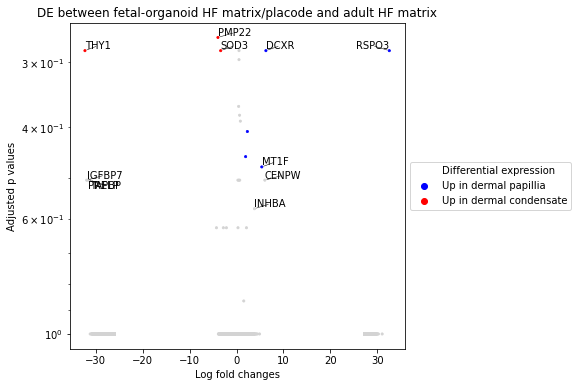

In [254]:
sk.set_figsize((6, 6))
ax = sn.scatterplot(
    data=ad_fibro_deg0,
    x="logfoldchanges",
    y="pvals_adj",
    s=5,
    hue="Differential expression",
    palette=["blue", "lightgrey", "red"],
    edgecolor=None,
    alpha=1,
)
# ax.set_xlim(-10, 10)
ax.set_yscale("log")
ax.invert_yaxis()
ax.set_xlabel("Log fold changes")
ax.set_ylabel("Adjusted p values")
ax.set_title("DE between fetal-organoid HF matrix/placode and adult HF matrix")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

texts = []
for g in top_de_genes:
    k = ad_fibro_deg0.genes == g
    texts.append(
        ax.text(
            ad_fibro_deg0.logfoldchanges[k],
            ad_fibro_deg0.pvals_adj[k],
            s=g,
            fontdict={"fontsize": 10},
        )
    )
adjust_text(
    texts,
    force_points=5,
    force_text=5,
    expand_points=(1, 1),
    expand_text=(1, 1),
    arrowprops=dict(arrowstyle="-", color="black", lw=0.5),
)
# ax.get_figure().savefig("figS2D_matrix_DEG.20221021.pdf", bbox_inches="tight")

In [269]:
pre_DC_genes = list(
    set(
        """BMP4
BMP7
EDN3
FGF10
FOXD1
FOXD1
SOX2
""".upper().split()
    )
)

In [270]:
DC_genes = list(
    set(
        """BMP7
BMP4
CXCR4
ENPP2
Hhip
FGF10
FOXD1
NRP2
PRDM1
PROM1
SOX2
TBX18
SOX2
PDGFRA
P75
palm3 cpn2 kcns2 csn3 adamts18 obscn lrcc15 nrxn2 btla stmn2 clic5 hck igfbp2 ripor2 tagln
Epha3, Hic1, Itgα11, Igbfp2, Mcam, Pcp4, Pdgfrl, Tnnt1 RSPO3 Spock3, ADAMTS18 LGR6
""".upper()
        .replace(",", "")
        .split()
    )
)

In [271]:
DP_genes = list(
    set(
        """SOX2
Spock3, Cadm2, sfrp4, gpr165, sfrp2, rspo3, nrg2, chodl, smpd3, cntn1, amph, gldn2, aadacl2, pappa2, ildr2
Fgf7, Hey2, Pax1, Prlr, Rspo3, Sostdc1, Vcan Runx3 Rspo2, Itga5 CD200
Chodl, Crabp1, Dio2, Edn3, Gpm6b, Gpx3, Hhip, Pappa2, Rspo2, Sfrp1 Sfrp2, Sostdc, and Sparcl1
""".upper()
        .replace(",", "")
        .split()
    )
)

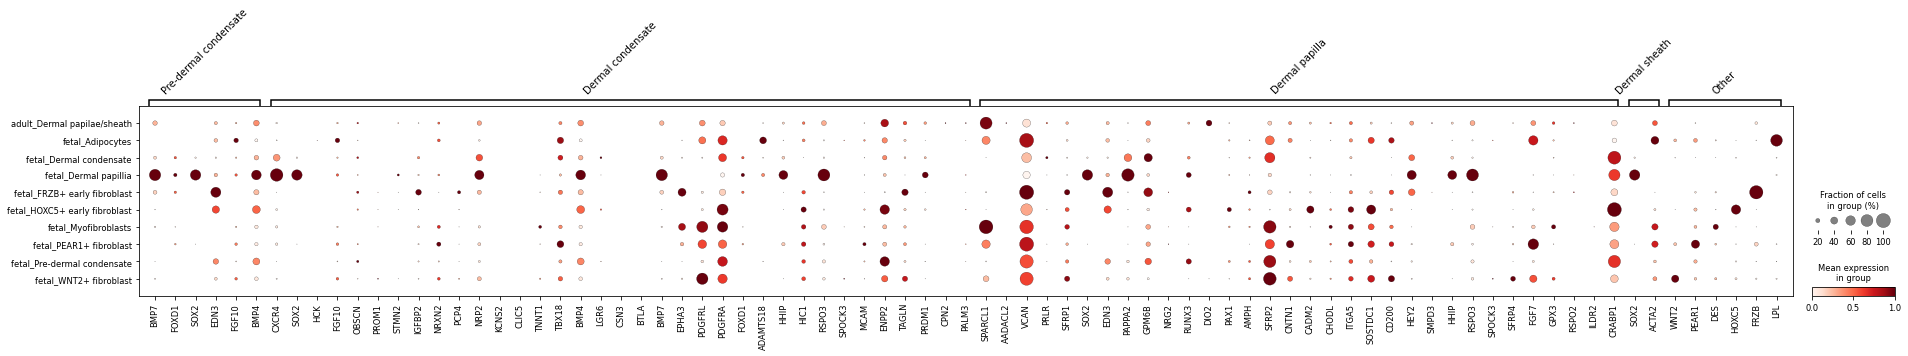

In [279]:
sc.pl.dotplot(
    pooled_ad1c,
    {
        "Pre-dermal condensate": [g for g in pre_DC_genes if g in pooled_ad1c.raw.var_names],
        "Dermal condensate":  [g for g in DC_genes if g in pooled_ad1c.raw.var_names],
        "Dermal papilla":  [g for g in DP_genes if g in pooled_ad1c.raw.var_names],
        "Dermal sheath": ["SOX2", "ACTA2"],
        "Other": ["WNT2", "PEAR1", "DES", "HOXC5", "FRZB", "LPL"]
    },
    groupby="annot",
    var_group_rotation=45,
    standard_scale="var",
)

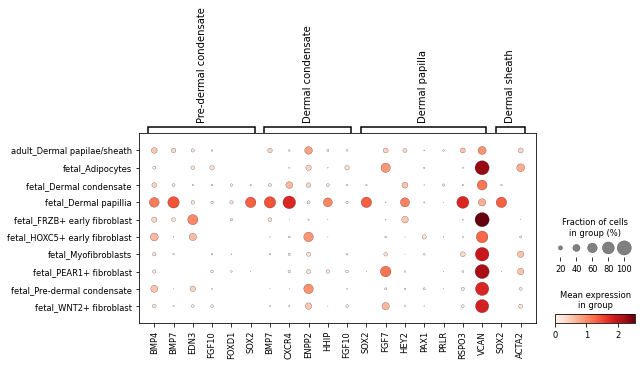

In [258]:
sc.pl.dotplot(
    pooled_ad1c,
    {
        "Pre-dermal condensate": ["BMP4", "BMP7", "EDN3", "FGF10", "FOXD1", "SOX2"],
        "Dermal condensate": ["BMP7", "CXCR4", "ENPP2", "HaHIP", "FGF10"],
        "Dermal papilla": ["SOX2", "HEY2", "PAX1", "RSPO3"],
        "Dermal sheath": ["SOX2", "ACTA2"],
    },
    groupby="annot",
)

In [256]:
pooled_ad1c

AnnData object with n_obs × n_vars = 932 × 3341
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'annot', 'independent_annotation_refined_20220202', 'fig1b_annotation_20220202', 'rie20_annot', 'rie20_annot_prob', 'rie20_annot5

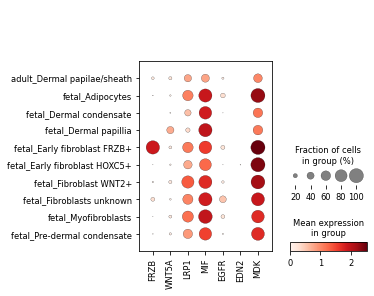

In [431]:
sk.pl.dotplot(pooled_ad1c, ["FRZB", "WNT5A", "LRP1", "MIF", "EGFR", "EDN2", "MDK"], groupby="annot")

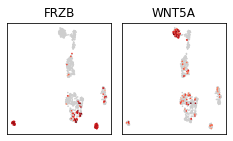

In [426]:
sk.plot_genes(
    pooled_ad1c[pooled_ad1c.obs.dataset == "fetal"],
    basis="umap_hm",
    genes=["FRZB", "WNT5A"],
    size=10,
);

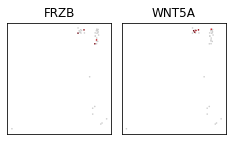

In [427]:
sk.plot_genes(
    pooled_ad1c[pooled_ad1c.obs.dataset == "adult"],
    basis="umap_hm",
    genes=["FRZB", "WNT5A"],
    size=10,
);

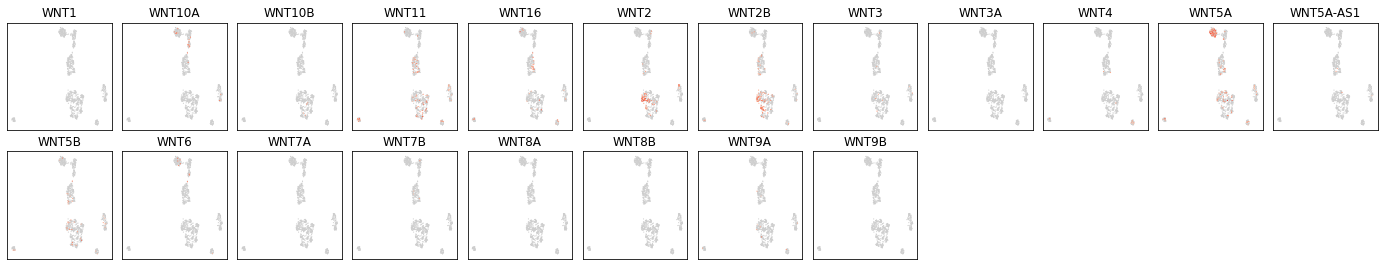

In [440]:
sk.plot_genes(
    pooled_ad1c,
    basis="umap_hm",
    genes=pooled_ad1c.raw.var_names[pd.Series(pooled_ad1c.raw.var_names).str.startswith("WNT")],
    figsize=(2, 2),
    size=5,
    vmin=0,
    vmax=4,
)

## T

In [450]:
pooled_ad1.obs.independent_annotation_broad3.unique()

array(['Granulocyte progenitor', 'DC', 'MEMP', 'HSC', 'ILC', 'B cell', 'Muscle', 'Lymphatic endothelium', 'Macrophage', 'Monocyte',
       'Monocyte precursor', 'Mast cell', 'Vascular endothelium', 'Megakaryocyte', 'Myofibroblast', 'Erythroid', 'Pericyte', 'Dermal condensate',
       'Fibroblast', 'Neuronal cells', 'NK cell', 'Langerhans cell', 'Neutrophil', 'Microglia', 'NK T cell', 'CD4 T cell', 'KC', 'Melanocyte',
       'CD8 T cell', 'Treg', 'Adipocyte', nan], dtype=object)

In [456]:
pooled_T_ad1a = pooled_ad1[
    pooled_ad1.obs.independent_annotation_broad3.isin(
        ["ILC", "NK cell", "NK T cell", "CD4 T cell", "CD8 T cell", "Treg"]
    )
    | (pooled_ad1.obs.annot == "adult_T")
].copy()

In [457]:
pooled_T_ad1b = pooled_T_ad1a[
    pooled_T_ad1a.obs.batch.isin(
        sk._pipeline.get_good_sized_batch(pooled_T_ad1a.obs.batch, min_size=5)
    )
].copy()

In [458]:
pooled_T_ad1c = sk.simple_default_pipeline(
    pooled_T_ad1b,
    post_filter_only=True,
    do_clustering=False,
    batch="batch",
    batch_method="harmony",
    hvg_kw={"by_batch": ("batch", 1), "n_hvg": 2000},
    pca_kw={"remove_genes": ("mito", "ribo")},
)

... storing 'sanger_id' as categorical
... storing 'chemistry' as categorical
... storing 'batch' as categorical
... storing 'gender' as categorical
... storing 'sorting' as categorical
... storing 'sample' as categorical
... storing 'chemistry_sorting' as categorical
... storing 'cell_caller' as categorical
... storing 'independent_annotation_refined' as categorical
... storing 'independent_annotation_broad1' as categorical
... storing 'independent_annotation_broad2' as categorical
... storing 'independent_annotation_broad3' as categorical
... storing 'independent_annotation_broad4' as categorical
... storing 'independent_annotation_broad5' as categorical
... storing 'annot' as categorical
... storing 'is_maternal' as categorical
... storing 'fig1b_annotation' as categorical
... storing 'rie20_annot' as categorical
... storing 'rie20_annot50' as categorical
... storing 'platform' as categorical
... storing 'leiden_hm_r0_1' as categorical
... storing 'leiden_hm_r0_3' as categorical
...

2021-12-08 09:40:55,140 - harmonypy - INFO - Iteration 1 of 20
2021-12-08 09:40:55,306 - harmonypy - INFO - Iteration 2 of 20
2021-12-08 09:40:55,435 - harmonypy - INFO - Iteration 3 of 20
2021-12-08 09:40:55,534 - harmonypy - INFO - Iteration 4 of 20
2021-12-08 09:40:55,604 - harmonypy - INFO - Iteration 5 of 20
2021-12-08 09:40:55,703 - harmonypy - INFO - Iteration 6 of 20
2021-12-08 09:40:55,780 - harmonypy - INFO - Iteration 7 of 20
2021-12-08 09:40:55,857 - harmonypy - INFO - Iteration 8 of 20
2021-12-08 09:40:55,949 - harmonypy - INFO - Iteration 9 of 20
2021-12-08 09:40:56,004 - harmonypy - INFO - Iteration 10 of 20
2021-12-08 09:40:56,059 - harmonypy - INFO - Iteration 11 of 20
2021-12-08 09:40:56,165 - harmonypy - INFO - Iteration 12 of 20
2021-12-08 09:40:56,242 - harmonypy - INFO - Iteration 13 of 20
2021-12-08 09:40:56,296 - harmonypy - INFO - Iteration 14 of 20
2021-12-08 09:40:56,358 - harmonypy - INFO - Iteration 15 of 20
2021-12-08 09:40:56,420 - harmonypy - INFO - Iter

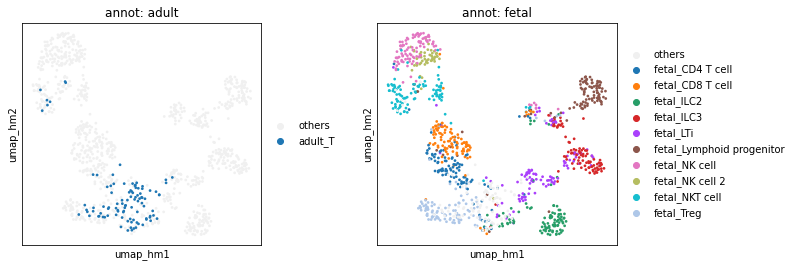

In [513]:
sk.highlight(
    pooled_T_ad1c,
    basis="umap_hm",
    groupby="annot",
    prefix_dict={"adult": "adult_", "fetal": "fetal_"},
    size=30,
    wspace=0.35,
);

In [502]:
sk.LR_predict(pooled_T_ad1c, adult_skin_lr, key_added="adult_sk_annot", min_prob=0.5)

20228 features used for prediction


In [523]:
sk.LR_predict(pooled_T_ad1c, fetal_skin_lr, key_added="fetal_sk_annot", min_prob=0.5)

20228 features used for prediction


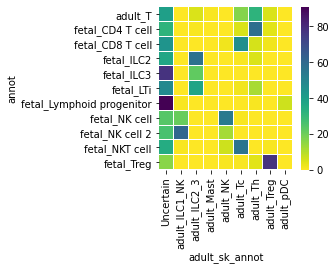

In [506]:
sk.cross_table(pooled_T_ad1c, "annot", "adult_sk_annot", normalise="x", plot=True, figsize=(3, 3));

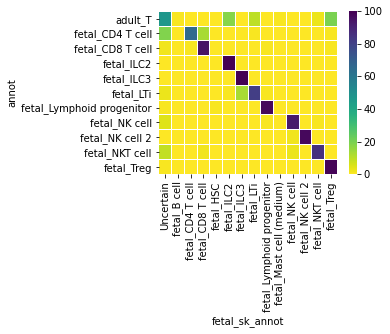

In [524]:
sk.cross_table(pooled_T_ad1c, "annot", "fetal_sk_annot", normalise="x", plot=True, figsize=(4, 3));

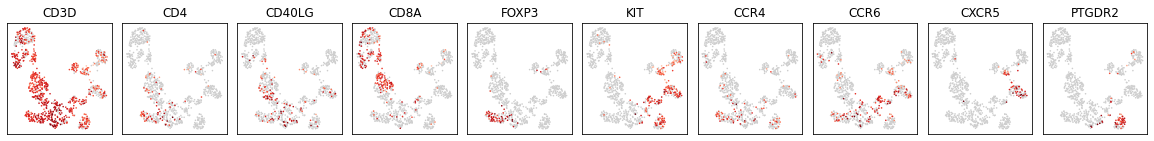

In [522]:
sk.plot_genes(
    pooled_T_ad1c,
    basis="umap_hm",
    genes=["CD3D", "CD4", "CD40LG", "CD8A", "FOXP3", "KIT", "CCR4", "CCR6", "CXCR5", "PTGDR2"],
    size=10,
)

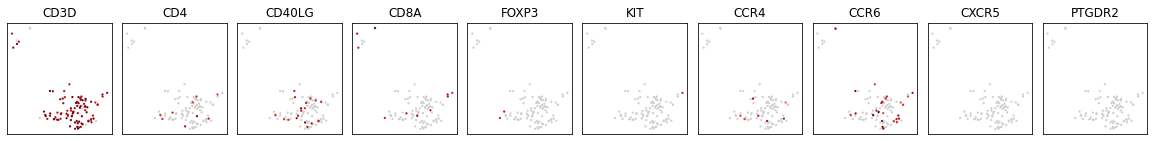

In [549]:
sk.plot_genes(
    pooled_T_ad1c[pooled_T_ad1c.obs.dataset == "adult"],
    basis="umap_hm",
    genes=["CD3D", "CD4", "CD40LG", "CD8A", "FOXP3", "KIT", "CCR4", "CCR6", "CXCR5", "PTGDR2"],
    size=20,
    vmin=0,
    vmax=3,
)

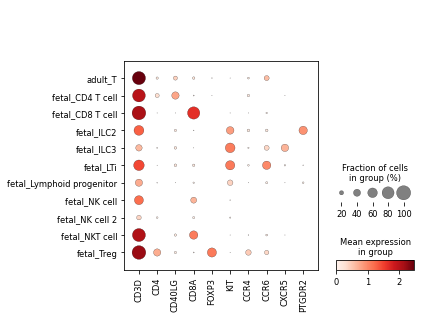

In [519]:
sk.pl.dotplot(
    pooled_T_ad1c,
    ["CD3D", "CD4", "CD40LG", "CD8A", "FOXP3", "KIT", "CCR4", "CCR6", "CXCR5", "PTGDR2"],
    groupby="annot",
)

## Myeloid

In [527]:
pooled_ad1.obs.independent_annotation_broad4.unique()

array(['Other blood cells', 'Lymphocytes', 'Muscle', 'Endothelium', 'Antigen Presenting Cells', 'Mesenchymal cells', 'Erythroid', 'Neuronal cells',
       'Epithelium', nan], dtype=object)

In [558]:
pooled_myl_ad1a = pooled_ad1[
    pooled_ad1.obs.independent_annotation_broad4.isin(["Antigen Presenting Cells"])
    | (pooled_ad1.obs.independent_annotation_refined == "LC")
    | (pooled_ad1.obs.annot.isin(["adult_LC", "adult_Macrophage"]))
].copy()

In [559]:
pooled_myl_ad1b = pooled_myl_ad1a[
    pooled_myl_ad1a.obs.batch.isin(
        sk._pipeline.get_good_sized_batch(pooled_myl_ad1a.obs.batch, min_size=5)
    )
].copy()

In [560]:
pooled_myl_ad1c = sk.simple_default_pipeline(
    pooled_myl_ad1b,
    post_filter_only=True,
    do_clustering=False,
    batch="batch",
    batch_method="harmony",
    hvg_kw={"by_batch": ("batch", 1), "n_hvg": 2000},
    pca_kw={"remove_genes": ("mito", "ribo")},
)

... storing 'sanger_id' as categorical
... storing 'chemistry' as categorical
... storing 'batch' as categorical
... storing 'gender' as categorical
... storing 'sorting' as categorical
... storing 'sample' as categorical
... storing 'chemistry_sorting' as categorical
... storing 'cell_caller' as categorical
... storing 'independent_annotation_refined' as categorical
... storing 'independent_annotation_broad1' as categorical
... storing 'independent_annotation_broad2' as categorical
... storing 'independent_annotation_broad3' as categorical
... storing 'independent_annotation_broad4' as categorical
... storing 'independent_annotation_broad5' as categorical
... storing 'annot' as categorical
... storing 'is_maternal' as categorical
... storing 'fig1b_annotation' as categorical
... storing 'rie20_annot' as categorical
... storing 'rie20_annot50' as categorical
... storing 'platform' as categorical
... storing 'leiden_hm_r0_1' as categorical
... storing 'leiden_hm_r0_3' as categorical
...

2021-12-08 11:42:35,706 - harmonypy - INFO - Iteration 1 of 20
2021-12-08 11:42:35,989 - harmonypy - INFO - Iteration 2 of 20
2021-12-08 11:42:36,125 - harmonypy - INFO - Iteration 3 of 20
2021-12-08 11:42:36,286 - harmonypy - INFO - Iteration 4 of 20
2021-12-08 11:42:36,555 - harmonypy - INFO - Iteration 5 of 20
2021-12-08 11:42:36,835 - harmonypy - INFO - Iteration 6 of 20
2021-12-08 11:42:37,019 - harmonypy - INFO - Iteration 7 of 20
2021-12-08 11:42:37,179 - harmonypy - INFO - Iteration 8 of 20
2021-12-08 11:42:37,280 - harmonypy - INFO - Iteration 9 of 20
2021-12-08 11:42:37,560 - harmonypy - INFO - Iteration 10 of 20
2021-12-08 11:42:37,720 - harmonypy - INFO - Iteration 11 of 20
2021-12-08 11:42:37,820 - harmonypy - INFO - Iteration 12 of 20
2021-12-08 11:42:37,921 - harmonypy - INFO - Converged after 12 iterations


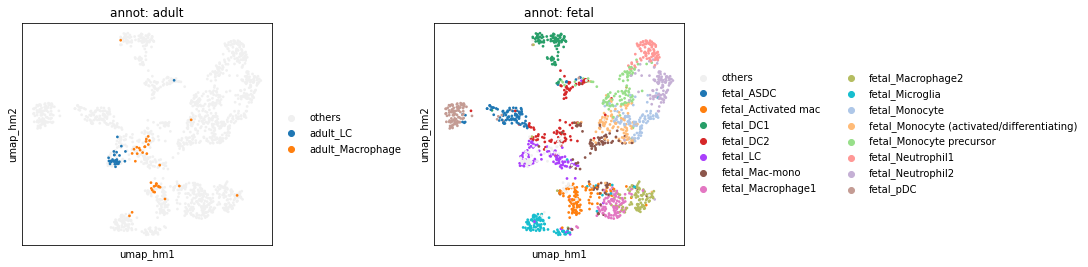

In [561]:
sk.highlight(
    pooled_myl_ad1c,
    basis="umap_hm",
    groupby="annot",
    prefix_dict={"adult": "adult_", "fetal": "fetal_"},
    size=30,
    wspace=0.5,
);

In [562]:
sk.LR_predict(pooled_myl_ad1c, adult_skin_lr, key_added="adult_sk_annot", min_prob=0.5)

20228 features used for prediction


In [563]:
sk.LR_predict(pooled_myl_ad1c, fetal_skin_lr, key_added="fetal_sk_annot", min_prob=0.5)

20228 features used for prediction


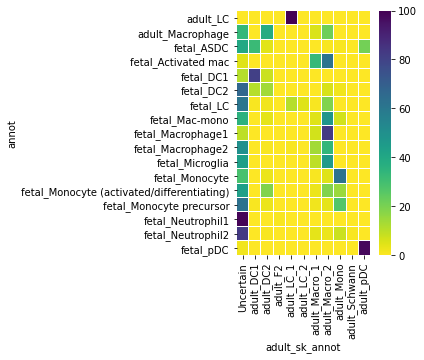

In [564]:
sk.cross_table(
    pooled_myl_ad1c, "annot", "adult_sk_annot", normalise="x", plot=True, figsize=(3, 4.5)
);

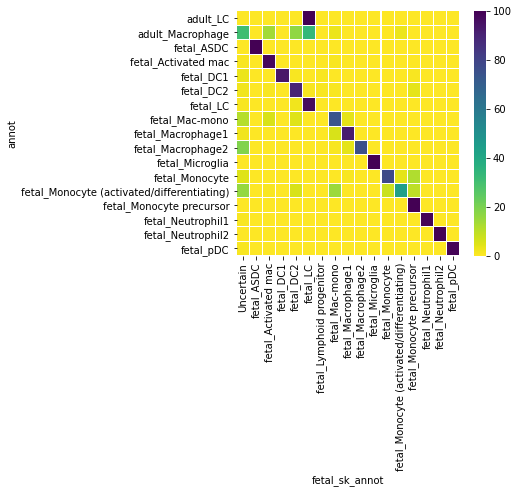

In [565]:
sk.cross_table(
    pooled_myl_ad1c, "annot", "fetal_sk_annot", normalise="x", plot=True, figsize=(5, 4.5)
);

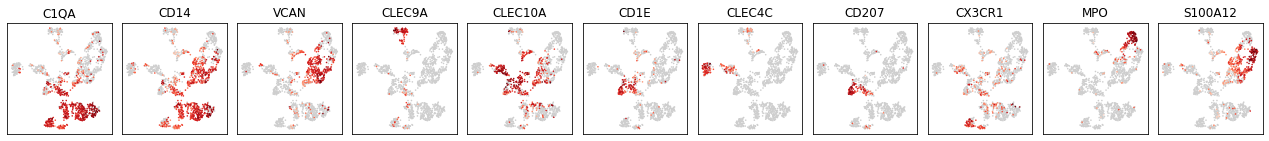

In [581]:
sk.plot_genes(
    pooled_myl_ad1c,
    basis="umap_hm",
    genes=[
        "C1QA",
        "CD14",
        "VCAN",
        "CLEC9A",
        "CLEC10A",
        "CD1E",
        "CLEC4C",
        "CD207",
        "CX3CR1",
        "MPO",
        "S100A12",
    ],
    size=10,
)

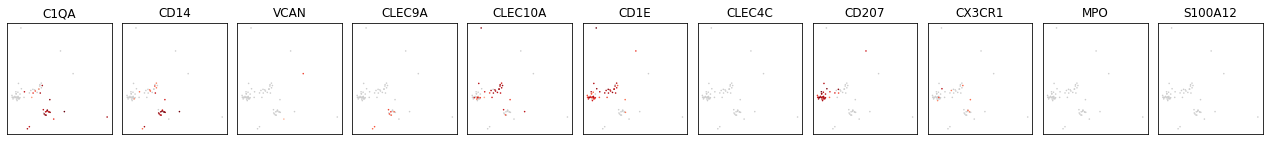

In [585]:
sk.plot_genes(
    pooled_myl_ad1c[pooled_myl_ad1c.obs.dataset == "adult"],
    basis="umap_hm",
    genes=[
        "C1QA",
        "CD14",
        "VCAN",
        "CLEC9A",
        "CLEC10A",
        "CD1E",
        "CLEC4C",
        "CD207",
        "CX3CR1",
        "MPO",
        "S100A12",
    ],
    vmin=0,
    vmax=3,
    size=10,
)

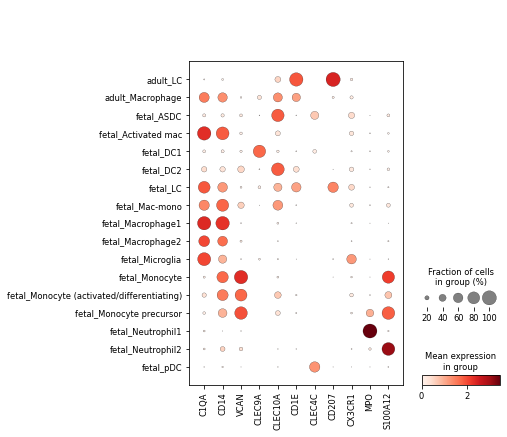

In [582]:
sk.pl.dotplot(
    pooled_myl_ad1c,
    [
        "C1QA",
        "CD14",
        "VCAN",
        "CLEC9A",
        "CLEC10A",
        "CD1E",
        "CLEC4C",
        "CD207",
        "CX3CR1",
        "MPO",
        "S100A12",
    ],
    groupby="annot",
)

## KC

In [155]:
fsk_org_ad

AnnData object with n_obs × n_vars = 3776 × 15192
    obs: 'batch', 'chemistry_sorting', 'dataset', 'day', 'donor', 'gender', 'n_counts', 'n_genes', 'nh3_annot1', 'percent_hb', 'percent_mito', 'percent_ribo', 'percent_top50', 'rachel_annot3', 'sample_id', 'sanger_id', 'strain', 'week', 'annot', 'leiden_hm_r0_1', 'leiden_hm_r0_3', 'leiden_hm_r0_5', 'leiden_hm_r0_7', 'leiden_hm_r0_9', 'annot1', 'joint_annot', 'leiden_hm_split1', 'orig_dataset', 'rie20_pred', 'rie20_pred_prob'
    var: 'gene_ids', 'hb', 'cc', 'mito', 'ribo', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'hvg_full'
    uns: 'leiden', 'neighbors', 'neighbors_hm', 'pca', 'rie20_pred_colors'
    obsm: 'X_pca', 'X_pca_hm', 'X_umap_hm'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [234]:
fsk_org_ad.obs.joint_annot.cat.categories

Index(['Periderm', 'Immature basal', 'Immature suprabasal', 'Basal',
       'POSTN+ basal', 'Matrix/placode', 'Cuticle/cortex', 'Outer root sheath',
       'Inner root sheath', 'Companion layer', 'Suprabasal IFE'],
      dtype='object')

In [235]:
sk.LR_train(fsk_org_ad, groupby="joint_annot", save="fsk_org_KC_joint_annot.lognorm.pkl")

LogisticRegression(C=0.1, n_jobs=-1, solver='saga', warm_start=True)

In [285]:
sk.LR_train(
    fsk_org_ad[fsk_org_ad.obs.dataset == "fetal_skin"],
    groupby="joint_annot",
    save="fsk_KC_joint_annot.lognorm.pkl",
)

LogisticRegression(C=0.1, n_jobs=-1, solver='saga', warm_start=True)

In [286]:
sk.LR_train(
    fsk_org_ad[fsk_org_ad.obs.dataset == "organoid"],
    groupby="joint_annot",
    save="org_KC_joint_annot.lognorm.pkl",
)

LogisticRegression(C=0.1, n_jobs=-1, solver='saga', warm_start=True)

In [236]:
sk.LR_predict(ad3a, "fsk_org_KC_joint_annot.lognorm.pkl", key_added="fsk_org_KC_pred")

15117 features used for prediction


In [287]:
sk.LR_predict(ad3a, "fsk_KC_joint_annot.lognorm.pkl", key_added="fsk_KC_pred")

15117 features used for prediction


In [288]:
sk.LR_predict(ad3a, "org_KC_joint_annot.lognorm.pkl", key_added="org_KC_pred")

15117 features used for prediction


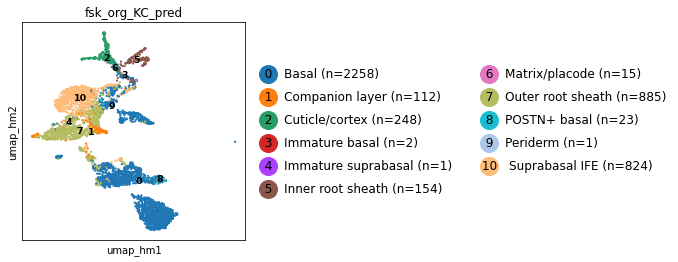

In [349]:
sk.plot_embedding(
    ad3a, basis="umap_hm", groupby="fsk_org_KC_pred", annot="full", figsize=(4, 4), size=20
);

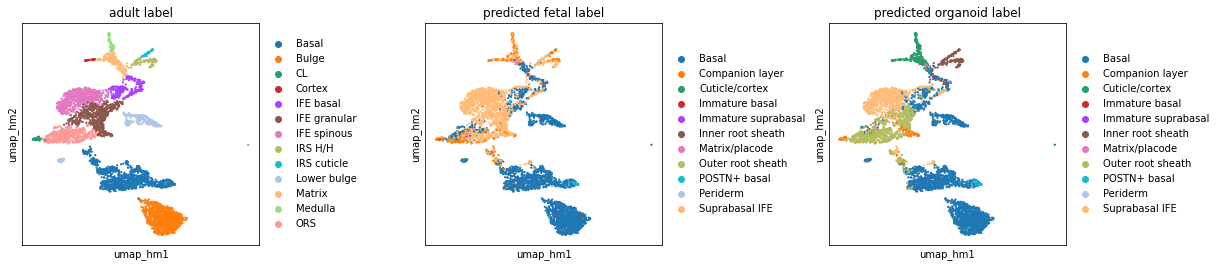

In [361]:
sk.clear_colors(ad3a)
sk.set_figsize((4, 4))
sc.pl.embedding(
    ad3a,
    basis="umap_hm",
    color=["nh3_annot2", "fsk_KC_pred", "org_KC_pred"],
    size=20,
    wspace=0.55,
    title=["adult label", "predicted fetal label", "predicted organoid label"],
);

In [344]:
selected_adult_cell_types = [
    "Basal",
    "ORS",
    "CL",
    "IRS H/H",
    "IRS cuticle",
    "Matrix",
    # "Medulla",
    "Cortex",
]
selected_fetal_cell_types = [
    "Basal",
    "Outer root sheath",
    "Companion layer",
    "Inner root sheath",
    "Matrix/placode",
    "Cuticle/cortex",
]

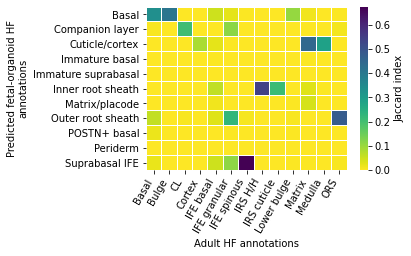

In [284]:
ax = sk.heatmap(
    sk.cross_table(ad3a, "fsk_org_KC_pred", "nh3_annot2", normalise="jaccard"),
    cmap="viridis_r",
    figsize=(4.5, 3),
    cbar_kws={"label": "Jaccard index"},
)
ax.set_xlabel("Adult HF annotations")
ax.set_ylabel("Predicted fetal-organoid HF\nannotations")
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right", va="top");

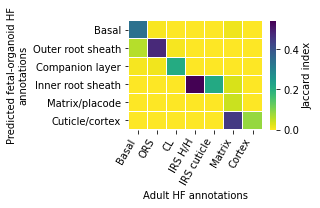

In [393]:
ax = sk.heatmap(
    sk.cross_table(ad3a, "fsk_org_KC_pred", "nh3_annot2", normalise="jaccard").loc[
        selected_fetal_cell_types, selected_adult_cell_types
    ],
    cmap="viridis_r",
    figsize=(3, 2),
    cbar_kws={"label": "Jaccard index"},
)
ax.set_xlabel("Adult HF annotations")
ax.set_ylabel("Predicted fetal-organoid HF\nannotations")
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right", va="top");

In [394]:
ax.get_figure().savefig("figS2D.20220928.pdf", bbox_inches="tight")

In [395]:
!rclone copy --drive-shared-with-me figS2D.20220928.pdf "google:/Fetal Skin/Figures/Figs_from_Ni/"

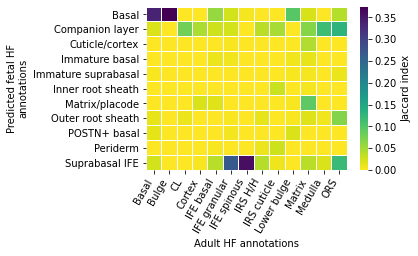

In [290]:
ax = sk.heatmap(
    sk.cross_table(ad3a, "fsk_KC_pred", "nh3_annot2", normalise="jaccard"),
    cmap="viridis_r",
    figsize=(4.5, 3),
    cbar_kws={"label": "Jaccard index"},
)
ax.set_xlabel("Adult HF annotations")
ax.set_ylabel("Predicted fetal HF\nannotations")
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right", va="top");

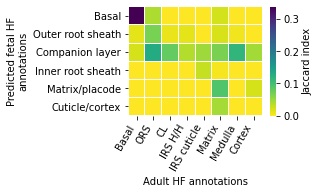

In [332]:
ax = sk.heatmap(
    sk.cross_table(ad3a, "fsk_KC_pred", "nh3_annot2", normalise="jaccard").loc[
        selected_fetal_cell_types, selected_adult_cell_types
    ],
    cmap="viridis_r",
    figsize=(3, 2),
    cbar_kws={"label": "Jaccard index"},
)
ax.set_xlabel("Adult HF annotations")
ax.set_ylabel("Predicted fetal HF\nannotations")
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right", va="top");

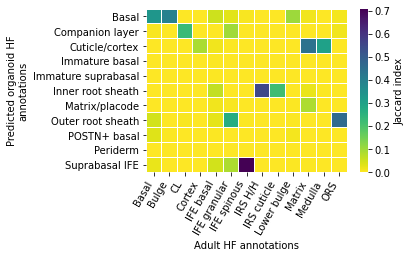

In [291]:
ax = sk.heatmap(
    sk.cross_table(ad3a, "org_KC_pred", "nh3_annot2", normalise="jaccard"),
    cmap="viridis_r",
    figsize=(4.5, 3),
    cbar_kws={"label": "Jaccard index"},
)
ax.set_xlabel("Adult HF annotations")
ax.set_ylabel("Predicted organoid HF\nannotations")
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right", va="top");

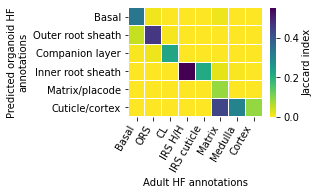

In [333]:
ax = sk.heatmap(
    sk.cross_table(ad3a, "org_KC_pred", "nh3_annot2", normalise="jaccard").loc[
        selected_fetal_cell_types, selected_adult_cell_types
    ],
    cmap="viridis_r",
    figsize=(3, 2),
    cbar_kws={"label": "Jaccard index"},
)
ax.set_xlabel("Adult HF annotations")
ax.set_ylabel("Predicted organoid HF\nannotations")
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right", va="top");

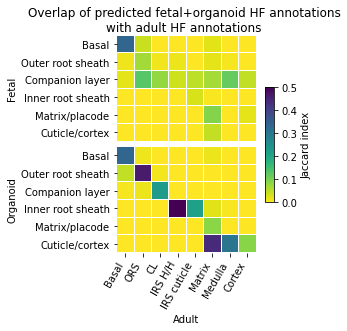

In [343]:
sk.set_figsize((2.5, 4))
fig, axs = plt.subplots(
    nrows=2,
    ncols=1,
    sharex=False,
    sharey=True,
    constrained_layout=False,
    gridspec_kw={"hspace": 0.05},
)

ht1 = sn.heatmap(
    sk.cross_table(ad3a, "fsk_KC_pred", "nh3_annot2", normalise="jaccard").loc[
        selected_fetal_cell_types, selected_adult_cell_types
    ],
    cmap="viridis_r",
    vmin=0,
    vmax=0.5,
    linewidth=0.01,
    cbar=False,
    ax=axs[0],
)

ht2 = sn.heatmap(
    sk.cross_table(ad3a, "org_KC_pred", "nh3_annot2", normalise="jaccard").loc[
        selected_fetal_cell_types, selected_adult_cell_types
    ],
    cmap="viridis_r",
    vmin=0,
    vmax=0.5,
    linewidth=0.01,
    cbar=False,
    ax=axs[1],
)
# fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.3, 0.05, 0.4])
fig.colorbar(ht2.collections[0], cax=cbar_ax, ax=axs, label="Jaccard index")
axs[0].set_xlabel("")
axs[0].set_xticks([])
axs[0].set_ylabel("Fetal")
axs[1].set_xlabel("Adult")
axs[1].set_ylabel("Organoid")
# fig.supylabel("Predicted HF annotations")
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=60, ha="right", va="top")
fig.suptitle("Overlap of predicted fetal+organoid HF annotations\nwith adult HF annotations");

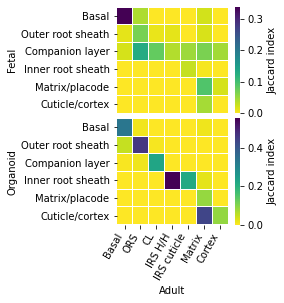

In [362]:
sk.set_figsize((2.5, 4))
fig, axs = plt.subplots(
    nrows=2,
    ncols=1,
    sharex=False,
    sharey=True,
    constrained_layout=False,
    gridspec_kw={"hspace": 0.05},
)

ht1 = sn.heatmap(
    sk.cross_table(ad3a, "fsk_KC_pred", "nh3_annot2", normalise="jaccard").loc[
        selected_fetal_cell_types, selected_adult_cell_types
    ],
    cmap="viridis_r",
    vmin=0,
    linewidth=0.01,
    ax=axs[0],
    cbar_kws={"label": "Jaccard index"},
)

ht2 = sn.heatmap(
    sk.cross_table(ad3a, "org_KC_pred", "nh3_annot2", normalise="jaccard").loc[
        selected_fetal_cell_types, selected_adult_cell_types
    ],
    cmap="viridis_r",
    vmin=0,
    linewidth=0.01,
    ax=axs[1],
    cbar_kws={"label": "Jaccard index"},
)
axs[0].set_xlabel("")
axs[0].set_xticks([])
axs[0].set_ylabel("Fetal")
axs[1].set_xlabel("Adult")
axs[1].set_ylabel("Organoid")
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=60, ha="right", va="top")
# fig.suptitle("Overlap of predicted fetal+organoid HF annotations\nwith adult HF annotations");

In [364]:
fig.savefig("figS2D.20220923.pdf", bbox_inches="tight")

In [365]:
!rclone copy --drive-shared-with-me figS2D.20220923.pdf "google:/Fetal Skin/Figures/Figs_from_Ni/"

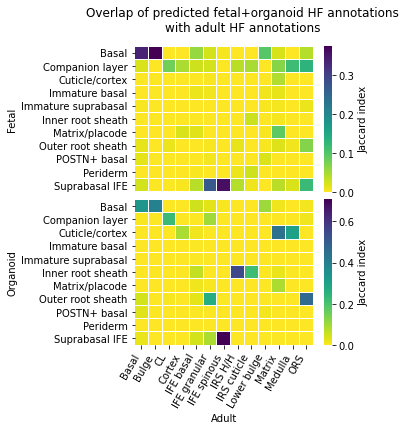

In [357]:
sk.set_figsize((4, 5.5))
fig, axs = plt.subplots(
    nrows=2,
    ncols=1,
    sharex=False,
    sharey=True,
    constrained_layout=False,
    gridspec_kw={"hspace": 0.05},
)

ht1 = sn.heatmap(
    sk.cross_table(ad3a, "fsk_KC_pred", "nh3_annot2", normalise="jaccard"),
    cmap="viridis_r",
    vmin=0,
    linewidth=0.01,
    ax=axs[0],
    cbar_kws={"label": "Jaccard index"},
)

ht2 = sn.heatmap(
    sk.cross_table(ad3a, "org_KC_pred", "nh3_annot2", normalise="jaccard"),
    cmap="viridis_r",
    vmin=0,
    linewidth=0.01,
    ax=axs[1],
    cbar_kws={"label": "Jaccard index"},
)
axs[0].set_xlabel("")
axs[0].set_xticks([])
axs[0].set_ylabel("Fetal")
axs[1].set_xlabel("Adult")
axs[1].set_ylabel("Organoid")
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=60, ha="right", va="top")
fig.suptitle("Overlap of predicted fetal+organoid HF annotations\nwith adult HF annotations");

In [24]:
fsk_org_ad.obs["orig_dataset"] = fsk_org_ad.obs.dataset.copy()

In [165]:
fsk_org_ad.obs.joint_annot.cat.rename_categories(
    {"Basal POSTN+": "POSTN+ basal", "Basal SHH+": "Matrix/placode"}, inplace=True
)

In [156]:
sk.LR_predict(fsk_org_ad, "rie20_lognorm.pkl", key_added="rie20_pred", min_prob=0.5)

15117 features used for prediction


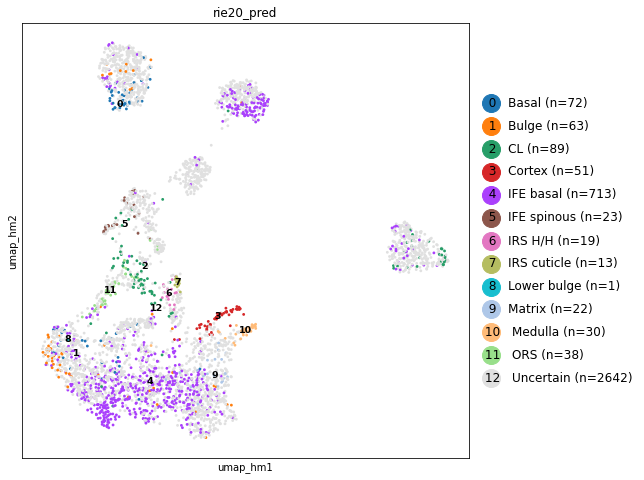

In [157]:
sk.plot_embedding(
    fsk_org_ad,
    basis="umap_hm",
    groupby="rie20_pred",
    figsize=(8, 8),
    greyout_group=["Uncertain", "Unknown"],
    use_uns_colors=False,
    annot="full",
);

Trying to set attribute `.uns` of view, copying.


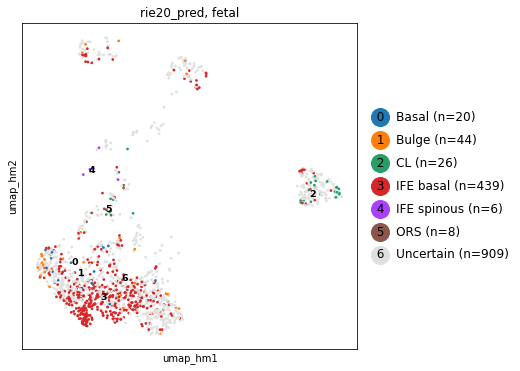

In [158]:
sk.plot_embedding(
    fsk_org_ad[fsk_org_ad.obs.dataset == "fetal_skin"],
    basis="umap_hm",
    groupby="rie20_pred",
    figsize=(6, 6),
    greyout_group=["Uncertain"],
    use_uns_colors=False,
    title="rie20_pred, fetal",
    size=30,
    annot="full",
);

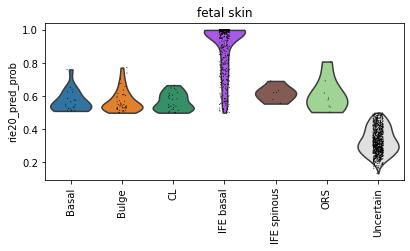

In [159]:
sk.set_figsize((6, 3))
sc.pl.violin(
    fsk_org_ad[fsk_org_ad.obs.dataset == "fetal_skin"],
    keys="rie20_pred_prob",
    groupby="rie20_pred",
    rotation=90,
    show=False,
)
plt.gca().set_title("fetal skin");

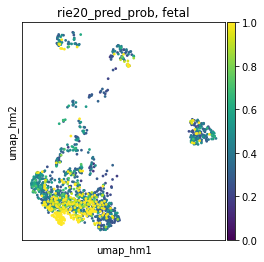

In [161]:
sk.set_figsize((4, 4))
sc.pl.embedding(
    fsk_org_ad[fsk_org_ad.obs.dataset == "fetal_skin"],
    basis="umap_hm",
    color="rie20_pred_prob",
    title="rie20_pred_prob, fetal",
    size=30,
    vmin=0,
    vmax=1,
);

Trying to set attribute `.uns` of view, copying.


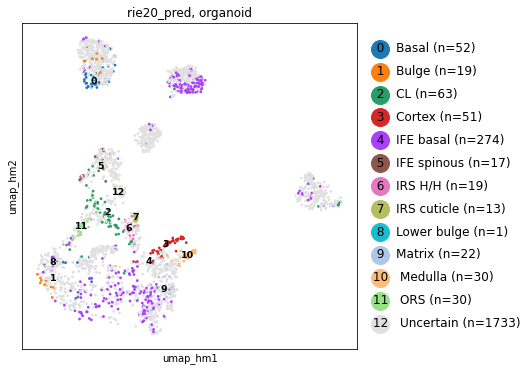

In [162]:
sk.plot_embedding(
    fsk_org_ad[fsk_org_ad.obs.dataset == "organoid"],
    basis="umap_hm",
    groupby="rie20_pred",
    figsize=(6, 6),
    greyout_group=["Uncertain", "Unknown"],
    use_uns_colors=False,
    annot="full",
    title="rie20_pred, organoid",
    size=30,
);

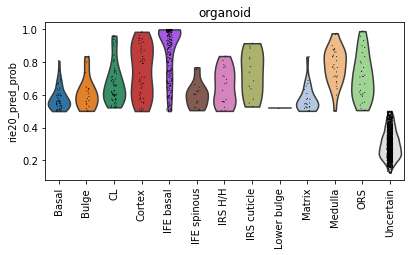

In [163]:
sk.set_figsize((6, 3))
sc.pl.violin(
    fsk_org_ad[fsk_org_ad.obs.dataset == "organoid"],
    keys="rie20_pred_prob",
    groupby="rie20_pred",
    rotation=90,
    show=False,
)
plt.gca().set_title("organoid");

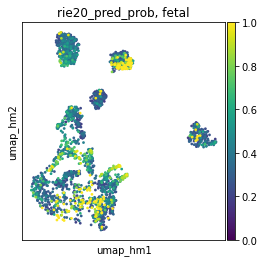

In [164]:
sk.set_figsize((4, 4))
sc.pl.embedding(
    fsk_org_ad[fsk_org_ad.obs.dataset == "organoid"],
    basis="umap_hm",
    color="rie20_pred_prob",
    title="rie20_pred_prob, fetal",
    size=30,
    vmin=0,
    vmax=1,
);

In [17]:
fsk_ad.obs.joint_annotation_20220202.cat.categories

Index(['ASDC', 'Iron-recycling macrophage', 'Adipocytes', 'Arterial', 'B cell',
       'Basal', 'POSTN+ basal', 'CD4 T cell', 'CD8 T cell',
       'Capillary (venular tip)', 'Capillary/postcapillary venule',
       'Companion layer', 'Cuticle/cortex', 'DC1', 'DC2', 'Dermal condensate',
       'Dermal papillia', 'Early LE', 'Early endothelial cell',
       'Early erythroid', 'Early erythroid (embryonic)',
       'FRZB+ early fibroblast', 'HOXC5+ early fibroblast', 'Early myocytes',
       'Eo/baso/mast cell progenitor', 'Erythroid (embryonic)',
       'Erythroid (fetal)', 'PEAR1+ fibroblast', 'WNT2+ fibroblast', 'HSC',
       'ILC2', 'ILC3', 'Immature basal', 'Immature suprabasal',
       'Inflammatory DC', 'Innate T type1', 'Innate T type3',
       'Inner root sheath', 'LC', 'LE', 'LTi', 'Lymphoid progenitor',
       'MEMP - Early erythroid', 'MEMP - Megak', 'MHCII+ macrophage',
       'LYVE1++ macrophage', 'Mast cell (earliest)', 'Mast cell (medium)',
       'Mast cell (most mature)',

In [168]:
fsk_org_ad.obs.joint_annot.value_counts()

Basal                  1272
Matrix/placode          494
POSTN+ basal            427
Periderm                337
Immature basal          318
Suprabasal IFE          230
Cuticle/cortex          213
Immature suprabasal     174
Inner root sheath       119
Companion layer         104
Outer root sheath        88
Name: joint_annot, dtype: int64

In [167]:
ad3

AnnData object with n_obs × n_vars = 5253 × 5021
    obs: 'platform', 'sample_id', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'leiden_hm_r0_1', 'leiden_hm_r0_3', 'leiden_hm_r0_5', 'leiden_hm_r0_7', 'leiden_hm_r0_9', 'leiden_hm_r0_2', 'leiden_hm_split1', 'leiden_hm_split2', 'leiden_hm_split3', 'leiden_hm_split4', 'leiden_hm_split5', 'leiden_hm_split6', 'leiden_hm_split7', 'annot', 'nh3_annot1', 'nh3_annot2'
    var: 'mito', 'ribo', 'hb', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std', 'hvg_full'
    uns: 'auto_filter_cells', 'hvg', 'leiden', 'neighbors_hm', 'pca', 'umap', 'nh3_annot1_colors', 'nh3_annot2_colors'
    obsm: 'X_pca', 'X_pca_hm', 'X_umap_hm'
    varm: 'PCs'
    obsp: 'neighbors_hm_connectivities', 'neighbors_hm_distances'

In [18]:
ad3a = ad3[
    ~ad3.obs.nh3_annot2.isin(
        [
            "LC",
            "Macrophage",
            "T",
            "Unknown",
            "Melanocyte",
            "Dermal papilae/sheath",
            "SM",
            "Sebaceous",
            "VE",
        ]
    )
].copy()

In [170]:
ad3Sa = ad3S[
    ~ad3S.obs.nh3_annot2.isin(
        [
            "LC",
            "Macrophage",
            "T",
            "Unknown",
            "Melanocyte",
            "Dermal papilae/sheath",
            "SM",
            "Sebaceous",
            "VE",
        ]
    )
].copy()

In [172]:
ad3Sa.obs.nh3_annot2.cat.categories

Index(['Basal', 'Bulge', 'CL', 'Cortex', 'IFE basal', 'IFE granular',
       'IFE spinous', 'IRS H/H', 'IRS cuticle', 'Lower bulge', 'Matrix',
       'Medulla', 'ORS'],
      dtype='object')

In [189]:
pooled_ad2 = sk.integrate(
    [fsk_org_ad, ad3Sa],
    ad_prefices=["fetal_org", "adult"],
    annotations=["joint_annot", "nh3_annot2"],
    batches=["donor", "sample_id"],
    join="outer",
    pool_only=True,
)

raw_norm
raw_norm


In [190]:
pooled_ad2.obs.loc[pooled_ad2.obs.orig_dataset.astype(str) == "nan", "orig_dataset"] = "adult"

In [191]:
pooled_ad2.obs["afo_joint_annot"] = (
    pooled_ad2.obs.orig_dataset.astype(str)
    + "_"
    + pooled_ad2.obs.annot.str.replace("fetal_org", "fetal-organoid").str.split("_", expand=True)[1]
)

In [192]:
pooled_ad2.var["cc"] = pooled_ad2.var_names.isin(sk.read_list("../data/misc/JP_cycle_genes.list"))

In [193]:
pooled_ad2a = sk.simple_default_pipeline(
    pooled_ad2,
    post_norm_only=True,
    do_clustering=False,
    batch="batch",
    batch_method="harmony",
    hvg_kw={"by_batch": ("batch", 1), "n_hvg": 2000},
    pca_kw={"remove_genes": ("mito", "ribo", "cc")},
)

... storing 'chemistry_sorting' as categorical
... storing 'day' as categorical
... storing 'batch' as categorical
... storing 'gender' as categorical
... storing 'nh3_annot1' as categorical
... storing 'rachel_annot3' as categorical
... storing 'sample_id' as categorical
... storing 'sanger_id' as categorical
... storing 'strain' as categorical
... storing 'week' as categorical
... storing 'leiden_hm_r0_1' as categorical
... storing 'leiden_hm_r0_3' as categorical
... storing 'leiden_hm_r0_5' as categorical
... storing 'leiden_hm_r0_7' as categorical
... storing 'leiden_hm_r0_9' as categorical
... storing 'annot1' as categorical
... storing 'annot' as categorical
... storing 'leiden_hm_split1' as categorical
... storing 'orig_dataset' as categorical
... storing 'rie20_pred' as categorical
... storing 'platform' as categorical
... storing 'leiden_hm_r0_2' as categorical
... storing 'leiden_hm_split2' as categorical
... storing 'leiden_hm_split3' as categorical
... storing 'leiden_hm_sp

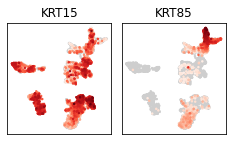

In [194]:
sk.plot_genes(
    pooled_ad2a,
    genes=["KRT15", "KRT85"],
    basis="umap_hm",
)

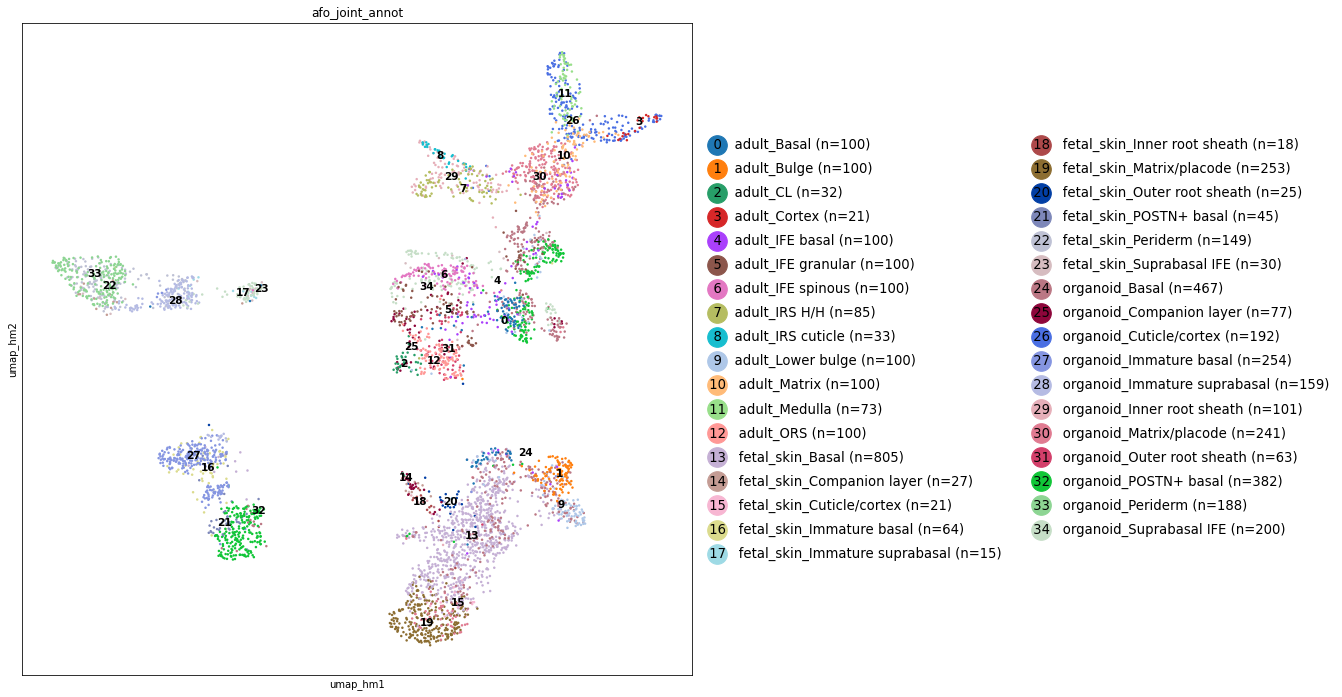

In [196]:
sk.plot_embedding(
    pooled_ad2a,
    basis="umap_hm",
    groupby="afo_joint_annot",
    annot="full",
    figsize=(12, 12),
    legend_fontsize=12,
);

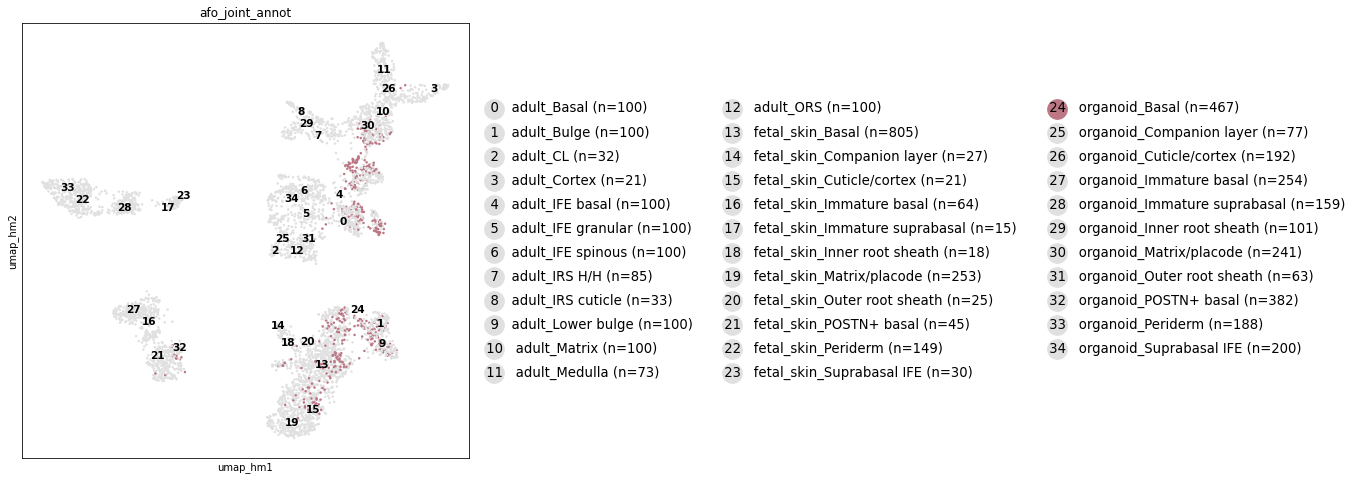

In [211]:
sk.plot_embedding(
    pooled_ad2a,
    basis="umap_hm",
    groupby="afo_joint_annot",
    annot="full",
    # highlight_group=["fetal_skin_Matrix/placode"],
    # highlight_group=["organoid_Matrix/placode"],
    highlight_group=["organoid_Basal"],
    use_uns_colors=False,
    figsize=(8, 8),
    legend_fontsize=12,
);

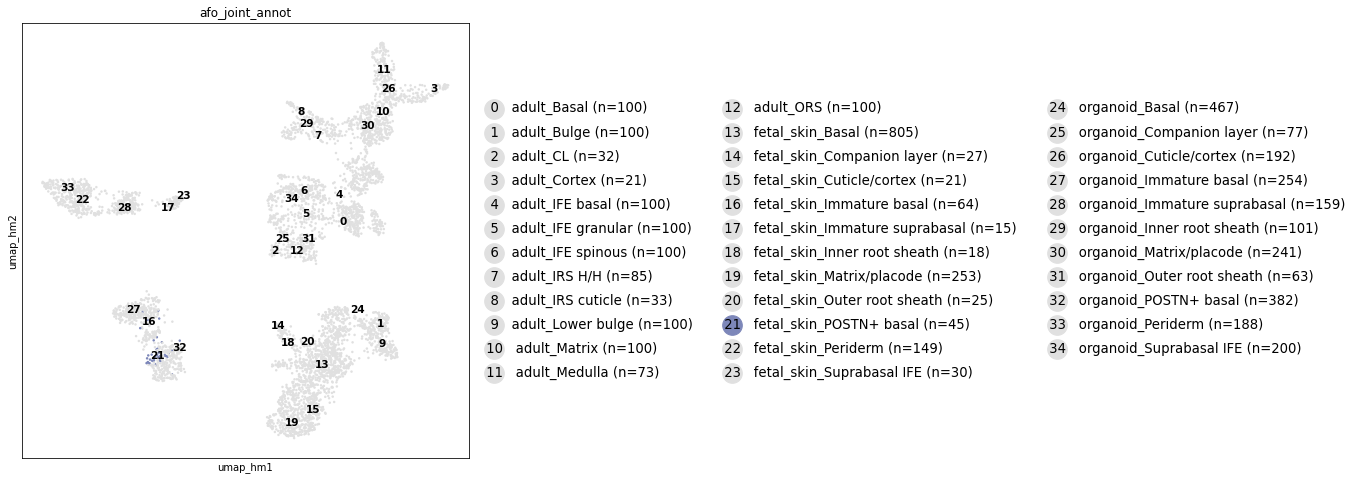

In [215]:
sk.plot_embedding(
    pooled_ad2a,
    basis="umap_hm",
    groupby="afo_joint_annot",
    annot="full",
    # highlight_group=["fetal_skin_Matrix/placode"],
    # highlight_group=["organoid_Matrix/placode"],
    highlight_group=["fetal_skin_POSTN+ basal"],
    use_uns_colors=False,
    figsize=(8, 8),
    legend_fontsize=12,
);

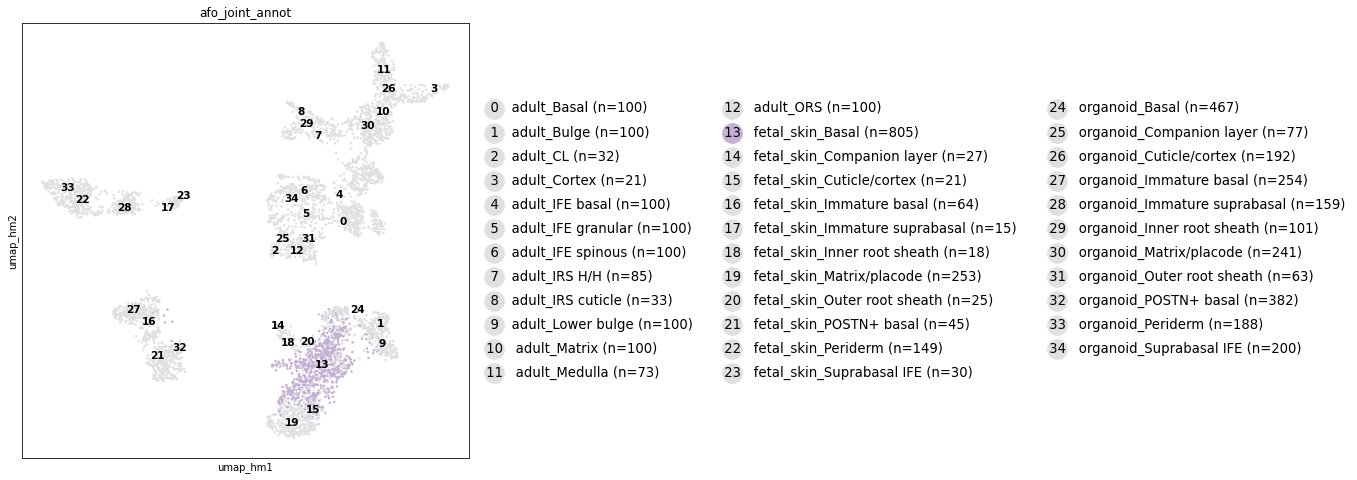

In [212]:
sk.plot_embedding(
    pooled_ad2a,
    basis="umap_hm",
    groupby="afo_joint_annot",
    annot="full",
    # highlight_group=["fetal_skin_Matrix/placode"],
    # highlight_group=["organoid_Matrix/placode"],
    highlight_group=["fetal_skin_Basal"],
    use_uns_colors=False,
    figsize=(8, 8),
    legend_fontsize=12,
);

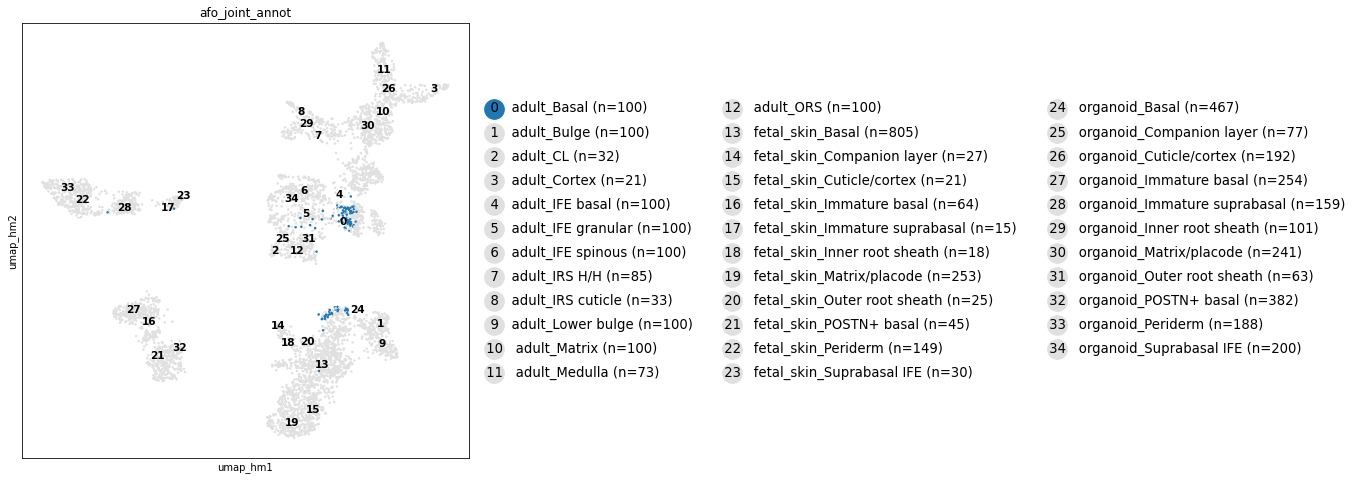

In [213]:
sk.plot_embedding(
    pooled_ad2a,
    basis="umap_hm",
    groupby="afo_joint_annot",
    annot="full",
    # highlight_group=["fetal_skin_Matrix/placode"],
    # highlight_group=["organoid_Matrix/placode"],
    highlight_group=["adult_Basal"],
    use_uns_colors=False,
    figsize=(8, 8),
    legend_fontsize=12,
);

In [40]:
pooled_ad3 = sk.integrate(
    [fsk_org_ad, ad3a],
    ad_prefices=["fetal_org", "adult"],
    annotations=["joint_annot", "nh3_annot2"],
    batches=["donor", "sample_id"],
    join="inner",
    pool_only=True,
)

raw_norm
raw_norm


In [41]:
pooled_ad3

AnnData object with n_obs × n_vars = 8299 × 15117
    obs: 'chemistry_sorting', 'dataset', 'day', 'batch', 'gender', 'n_counts', 'n_genes', 'nh3_annot1', 'percent_hb', 'percent_mito', 'percent_ribo', 'percent_top50', 'rachel_annot3', 'sample_id', 'sanger_id', 'strain', 'week', 'leiden_hm_r0_1', 'leiden_hm_r0_3', 'leiden_hm_r0_5', 'leiden_hm_r0_7', 'leiden_hm_r0_9', 'annot1', 'annot', 'leiden_hm_split1', 'orig_dataset', 'platform', 'log1p_n_counts', 'log1p_n_genes', 'n_counts_mito', 'n_counts_ribo', 'n_counts_hb', 'leiden_hm_r0_2', 'leiden_hm_split2', 'leiden_hm_split3', 'leiden_hm_split4', 'leiden_hm_split5', 'leiden_hm_split6', 'leiden_hm_split7'
    var: 'mito-adult', 'ribo-adult', 'hb-adult', 'n_counts-adult', 'n_cells-adult', 'gene_ids-fetal_skin-fetal_org', 'cc-fetal_skin-fetal_org', 'mito-fetal_skin-fetal_org', 'ribo-fetal_skin-fetal_org', 'hb-fetal_skin-fetal_org', 'n_cells-fetal_skin-fetal_org', 'highly_variable-fetal_skin-fetal_org', 'means-fetal_skin-fetal_org', 'dispersions-

In [42]:
pooled_ad3.obs.loc[pooled_ad3.obs.orig_dataset.astype(str) == "nan", "orig_dataset"] = "adult"

In [43]:
pooled_ad3.obs.annot.unique()

array(['fetal_org_Periderm', 'fetal_org_Immature basal', 'fetal_org_Immature suprabasal', 'fetal_org_Basal', 'fetal_org_Outer root sheath',
       'fetal_org_Cuticle/cortex', 'fetal_org_Basal SHH+', 'fetal_org_Basal POSTN+', 'fetal_org_Suprabasal IFE', 'fetal_org_Companion layer',
       'fetal_org_Inner root sheath', 'adult_IFE spinous', 'adult_IFE granular', 'adult_IFE basal', 'adult_Cortex', 'adult_Medulla', 'adult_ORS',
       'adult_IRS H/H', 'adult_Matrix', 'adult_Lower bulge', 'adult_IRS cuticle', 'adult_CL', 'adult_Basal', 'adult_Bulge'], dtype=object)

In [44]:
matrix_deg = sk.diffexp_paired(
    pooled_ad3, groupby="annot", pair=["fetal_org_Basal SHH+", "adult_Matrix"], method="wilcoxon"
)

... storing 'chemistry_sorting' as categorical
... storing 'day' as categorical
... storing 'batch' as categorical
... storing 'gender' as categorical
... storing 'nh3_annot1' as categorical
... storing 'rachel_annot3' as categorical
... storing 'sample_id' as categorical
... storing 'sanger_id' as categorical
... storing 'strain' as categorical
... storing 'week' as categorical
... storing 'leiden_hm_r0_1' as categorical
... storing 'leiden_hm_r0_3' as categorical
... storing 'leiden_hm_r0_5' as categorical
... storing 'leiden_hm_r0_7' as categorical
... storing 'leiden_hm_r0_9' as categorical
... storing 'annot1' as categorical
... storing 'annot' as categorical
... storing 'leiden_hm_split1' as categorical
... storing 'orig_dataset' as categorical
... storing 'platform' as categorical
... storing 'leiden_hm_r0_2' as categorical
... storing 'leiden_hm_split2' as categorical
... storing 'leiden_hm_split3' as categorical
... storing 'leiden_hm_split4' as categorical
... storing 'leiden

In [91]:
matrix_deg[1].loc[lambda x: (x.logfoldchanges > 2.5) & (x.pvals_adj < 0.05)].head(10)

cluster                   ref  rank     genes     scores  \
0  adult_Matrix  fetal_org_Basal SHH+     0     FABP5  17.729670   
1  adult_Matrix  fetal_org_Basal SHH+     1    CALML3  17.254778   
2  adult_Matrix  fetal_org_Basal SHH+     2      MT1X  16.802471   
3  adult_Matrix  fetal_org_Basal SHH+     3   TACSTD2  16.588243   
4  adult_Matrix  fetal_org_Basal SHH+     4      MT2A  14.444482   
5  adult_Matrix  fetal_org_Basal SHH+     5  MTRNR2L8  14.315522   
6  adult_Matrix  fetal_org_Basal SHH+     6     KRT85  14.219277   
7  adult_Matrix  fetal_org_Basal SHH+     7       ID2  14.046206   
8  adult_Matrix  fetal_org_Basal SHH+     8      MT1E  13.738055   
9  adult_Matrix  fetal_org_Basal SHH+     9    LGALS1  13.447001   

   logfoldchanges         pvals     pvals_adj  
0        3.874893  2.474886e-70  9.353213e-67  
1        4.908641  1.030167e-66  1.946629e-63  
2        4.519231  2.340845e-63  3.216960e-60  
3        4.035490  8.476418e-62  9.856770e-59  
4        3.513071  2.715935e-47  1.109643e-44  
5        3.916853  1.750441e-46  6.300336e-44  
6        3.862487  6.956713e-46  2.336992e-43  
7        2.711120  8.127225e-45  2.559568e-42  
8        6.896435  6.006754e-43  1.565588e-40  
9        2.749638  3.206170e-41  7.343587e-39

In [119]:
matrix_deg0 = matrix_deg[0].loc[
    lambda x: ~(
        x.genes.str.startswith("MT-")
        | x.genes.str.startswith("RBS")
        | x.genes.str.startswith("RBL")
    )
]

In [120]:
matrix_deg1 = matrix_deg[1].loc[
    lambda x: ~(
        x.genes.str.startswith("MT-")
        | x.genes.str.startswith("RBS")
        | x.genes.str.startswith("RBL")
    )
]

In [146]:
matrix_deg0["Differential expression"] = ""
matrix_deg0.loc[
    lambda x: (x.logfoldchanges > 1) & (x.pvals_adj < 0.05), "Differential expression"
] = "Up in fetal/organoid"
matrix_deg0.loc[
    lambda x: (x.logfoldchanges < -1) & (x.pvals_adj < 0.05), "Differential expression"
] = "Up in adult"

In [153]:
top_de_genes = (
    matrix_deg0.loc[lambda x: (x.logfoldchanges > 2.5) & (x.pvals_adj < 0.05)]
    .head(10)
    .genes.to_list()
    + matrix_deg1.loc[lambda x: (x.logfoldchanges > 2.5) & (x.pvals_adj < 0.05)]
    .head(10)
    .genes.to_list()
)

In [75]:
from adjustText import adjust_text

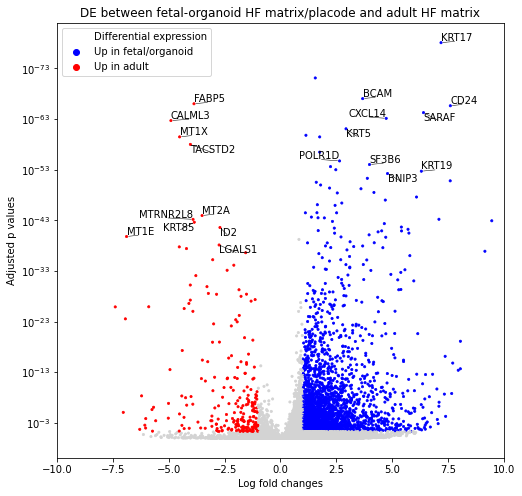

In [154]:
ax = sn.scatterplot(
    data=matrix_deg0,
    x="logfoldchanges",
    y="pvals_adj",
    s=5,
    hue="Differential expression",
    palette=["blue", "lightgrey", "red"],
    edgecolor=None,
    alpha=1,
)
ax.set_xlim(-10, 10)
ax.set_yscale("log")
ax.invert_yaxis()
ax.set_xlabel("Log fold changes")
ax.set_ylabel("Adjusted p values")
ax.set_title("DE between fetal-organoid HF matrix/placode and adult HF matrix")

texts = []
for g in top_de_genes:
    k = matrix_deg0.genes == g
    texts.append(
        ax.text(
            matrix_deg0.logfoldchanges[k],
            matrix_deg0.pvals_adj[k],
            s=g,
            fontdict={"fontsize": 10},
        )
    )
adjust_text(
    texts,
    force_points=0.2,
    force_text=0.2,
    expand_points=(1, 1),
    expand_text=(1, 1),
    arrowprops=dict(arrowstyle="-", color="black", lw=0.5),
)
ax.get_figure().savefig("figS2D_matrix_DEG.20221021.pdf", bbox_inches="tight")

In [150]:
!rclone copy --drive-shared-with-me figS2D_matrix_DEG.20221021.pdf "google:/Fetal Skin/Figures/Figs_from_Ni/"

In [159]:
fo_enriched = sc.queries.enrich(
    matrix_deg0.loc[lambda x: (x.logfoldchanges > 2.5) & (x.pvals_adj < 0.05)]
    .sort_values(["pvals_adj", "logfoldchanges"], ascending=[True, False])
    .head(50)
    .genes.to_list(),
).head(20)

In [160]:
adult_enriched = sc.queries.enrich(
    matrix_deg0.loc[lambda x: (x.logfoldchanges < -2.5) & (x.pvals_adj < 0.05)]
    .sort_values(["pvals_adj", "logfoldchanges"], ascending=[True, True])
    .head(50)
    .genes.to_list(),
).head(20)

In [161]:
adult_enriched.head()

source              native                           name       p_value  \
0  GO:BP          GO:0006882  cellular zinc ion homeostasis  2.736378e-09   
1  GO:BP          GO:0055069           zinc ion homeostasis  4.029635e-09   
2   REAC  REAC:R-HSA-5661231   Metallothioneins bind metals  1.540178e-08   
3   REAC  REAC:R-HSA-5660526         Response to metal ions  6.636970e-08   
4  GO:BP          GO:1990169  stress response to copper ion  1.281887e-07   

   significant                                        description  term_size  \
0         True  "Any process involved in the maintenance of an...         38   
1         True  "Any process involved in the maintenance of an...         40   
2         True                       Metallothioneins bind metals         11   
3         True                             Response to metal ions         14   
4         True  "Any process that results in a change in state...         14   

   query_size  intersection_size  effective_domain_size  precision    recall  \
0          45                  7                  21100   0.155556  0.184211   
1          45                  7                  21100   0.155556  0.175000   
2          29                  5                  10770   0.172414  0.454545   
3          29                  5                  10770   0.172414  0.357143   
4          45                  5                  21100   0.111111  0.357143   

     query                               parents  
0  query_1  [GO:0046916, GO:0055069, GO:0072503]  
1  query_1              [GO:0055076, GO:0072507]  
2  query_1                  [REAC:R-HSA-5660526]  
3  query_1                  [REAC:R-HSA-8953897]  
4  query_1              [GO:0046688, GO:0097501]

In [ ]:
sn.scatterplot(
    data=adult_enriched,
    x=
)

In [152]:
matrix_deg[0].head(20)

cluster           ref  rank   genes     scores  \
0   fetal_org_Basal SHH+  adult_Matrix     0   KRT17  19.300817   
1   fetal_org_Basal SHH+  adult_Matrix     1    TPT1  18.416044   
2   fetal_org_Basal SHH+  adult_Matrix     2    BCAM  17.877201   
3   fetal_org_Basal SHH+  adult_Matrix     3    CD24  17.666349   
4   fetal_org_Basal SHH+  adult_Matrix     4   SARAF  17.478926   
5   fetal_org_Basal SHH+  adult_Matrix     5  CXCL14  17.320419   
6   fetal_org_Basal SHH+  adult_Matrix     6    KRT5  17.030209   
7   fetal_org_Basal SHH+  adult_Matrix     7    NACA  16.851648   
8   fetal_org_Basal SHH+  adult_Matrix     8   GAPDH  16.795929   
9   fetal_org_Basal SHH+  adult_Matrix     9     FTL  16.370848   
10  fetal_org_Basal SHH+  adult_Matrix    10  POLR1D  16.121162   
11  fetal_org_Basal SHH+  adult_Matrix    11   SF3B6  16.015631   
12  fetal_org_Basal SHH+  adult_Matrix    12    CCNI  15.952522   
13  fetal_org_Basal SHH+  adult_Matrix    13   PNRC1  15.860078   
14  fetal_org_Basal SHH+  adult_Matrix    14   KRT19  15.814910   
15  fetal_org_Basal SHH+  adult_Matrix    15   BNIP3  15.744415   
16  fetal_org_Basal SHH+  adult_Matrix    16   PTCH2  15.603848   
17  fetal_org_Basal SHH+  adult_Matrix    17     MME  15.527232   
18  fetal_org_Basal SHH+  adult_Matrix    18   ZFAS1  15.482909   
19  fetal_org_Basal SHH+  adult_Matrix    19   ACTG1  15.399539   

    logfoldchanges         pvals     pvals_adj  significant  
0         7.193045  5.286612e-83  7.991772e-79         True  
1         1.558496  9.768790e-76  7.383740e-72         True  
2         3.681976  1.775276e-71  8.945617e-68         True  
3         7.610243  7.616868e-70  2.302884e-66         True  
4         6.407912  2.073665e-68  5.224598e-65         True  
5         4.737794  3.299493e-67  7.125490e-64         True  
6         2.936645  4.902994e-65  8.235395e-62         True  
7         1.141263  1.020300e-63  1.542387e-60         True  
8         1.757589  2.613826e-63  3.292767e-60         True  
9         1.757942  3.088774e-60  3.335214e-57         True  
10        2.647578  1.811714e-58  1.825846e-55         True  
11        3.988547  9.939421e-58  9.390889e-55         True  
12        2.241984  2.736171e-57  2.433100e-54         True  
13        2.479599  1.197463e-56  1.005669e-53         True  
14        6.312041  2.455603e-56  1.953755e-53         True  
15        4.796464  7.502150e-56  5.670500e-53         True  
16        3.891775  6.853614e-55  4.933623e-52         True  
17        7.604347  2.269677e-54  1.559578e-51         True  
18        1.603327  4.525400e-54  2.974369e-51         True  
19        1.799299  1.648401e-53  1.038286e-50         True

In [46]:
matrix_deg[1].head(20)

cluster                   ref  rank     genes     scores  \
0   adult_Matrix  fetal_org_Basal SHH+     0     FABP5  17.729670   
1   adult_Matrix  fetal_org_Basal SHH+     1    CALML3  17.254778   
2   adult_Matrix  fetal_org_Basal SHH+     2      MT1X  16.802471   
3   adult_Matrix  fetal_org_Basal SHH+     3   TACSTD2  16.588243   
4   adult_Matrix  fetal_org_Basal SHH+     4      MT2A  14.444482   
5   adult_Matrix  fetal_org_Basal SHH+     5  MTRNR2L8  14.315522   
6   adult_Matrix  fetal_org_Basal SHH+     6     KRT85  14.219277   
7   adult_Matrix  fetal_org_Basal SHH+     7       ID2  14.046206   
8   adult_Matrix  fetal_org_Basal SHH+     8      MT1E  13.738055   
9   adult_Matrix  fetal_org_Basal SHH+     9    LGALS1  13.447001   
10  adult_Matrix  fetal_org_Basal SHH+    10     NACA2  13.378827   
11  adult_Matrix  fetal_org_Basal SHH+    11      CD82  13.318041   
12  adult_Matrix  fetal_org_Basal SHH+    12       DBI  13.174096   
13  adult_Matrix  fetal_org_Basal SHH+    13    MRPL23  12.925465   
14  adult_Matrix  fetal_org_Basal SHH+    14    S100A8  12.824577   
15  adult_Matrix  fetal_org_Basal SHH+    15       ID3  12.727489   
16  adult_Matrix  fetal_org_Basal SHH+    16     GPNMB  12.539642   
17  adult_Matrix  fetal_org_Basal SHH+    17     U2AF1  12.339977   
18  adult_Matrix  fetal_org_Basal SHH+    18     ADIRF  11.983282   
19  adult_Matrix  fetal_org_Basal SHH+    19     ZNF90  11.918697   

    logfoldchanges         pvals     pvals_adj  
0         3.874893  2.474886e-70  9.353213e-67  
1         4.908641  1.030167e-66  1.946629e-63  
2         4.519231  2.340845e-63  3.216960e-60  
3         4.035490  8.476418e-62  9.856770e-59  
4         3.513071  2.715935e-47  1.109643e-44  
5         3.916853  1.750441e-46  6.300336e-44  
6         3.862487  6.956713e-46  2.336992e-43  
7         2.711120  8.127225e-45  2.559568e-42  
8         6.896435  6.006754e-43  1.565588e-40  
9         2.749638  3.206170e-41  7.343587e-39  
10        4.534261  8.040616e-41  1.736428e-38  
11        4.211258  1.818155e-40  3.765076e-38  
12        1.559849  1.236994e-39  2.460478e-37  
13        3.035911  3.233361e-38  6.026608e-36  
14       29.657988  1.194365e-37  2.124142e-35  
15        2.089698  4.160071e-37  7.146340e-35  
16        2.390515  4.530330e-36  7.208948e-34  
17        3.791449  5.517116e-35  8.340225e-33  
18        4.040911  4.347636e-33  5.974837e-31  
19        3.293022  9.457605e-33  1.254128e-30

In [28]:
pooled_ad3.obs["afo_joint_annot"] = (
    pooled_ad3.obs.orig_dataset.astype(str)
    + "_"
    + pooled_ad3.obs.annot.str.replace("fetal_org", "fetal-organoid").str.split("_", expand=True)[1]
)

In [206]:
pooled_ad3.var["cc"] = pooled_ad3.var_names.isin(sk.read_list("../data/misc/JP_cycle_genes.list"))

In [207]:
pooled_ad3a = sk.simple_default_pipeline(
    pooled_ad3,
    post_norm_only=True,
    do_clustering=False,
    batch="batch",
    batch_method="harmony",
    hvg_kw={"by_batch": ("batch", 1), "n_hvg": 2000},
    pca_kw={"remove_genes": ("mito", "ribo", "cc")},
)

... storing 'chemistry_sorting' as categorical
... storing 'day' as categorical
... storing 'batch' as categorical
... storing 'gender' as categorical
... storing 'nh3_annot1' as categorical
... storing 'rachel_annot3' as categorical
... storing 'sample_id' as categorical
... storing 'sanger_id' as categorical
... storing 'strain' as categorical
... storing 'week' as categorical
... storing 'leiden_hm_r0_1' as categorical
... storing 'leiden_hm_r0_3' as categorical
... storing 'leiden_hm_r0_5' as categorical
... storing 'leiden_hm_r0_7' as categorical
... storing 'leiden_hm_r0_9' as categorical
... storing 'annot1' as categorical
... storing 'annot' as categorical
... storing 'leiden_hm_split1' as categorical
... storing 'orig_dataset' as categorical
... storing 'rie20_pred' as categorical
... storing 'platform' as categorical
... storing 'leiden_hm_r0_2' as categorical
... storing 'leiden_hm_split2' as categorical
... storing 'leiden_hm_split3' as categorical
... storing 'leiden_hm_sp

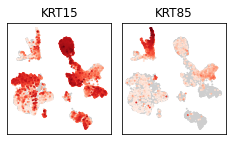

In [208]:
sk.plot_genes(
    pooled_ad3a,
    genes=["KRT15", "KRT85"],
    basis="umap_hm",
)

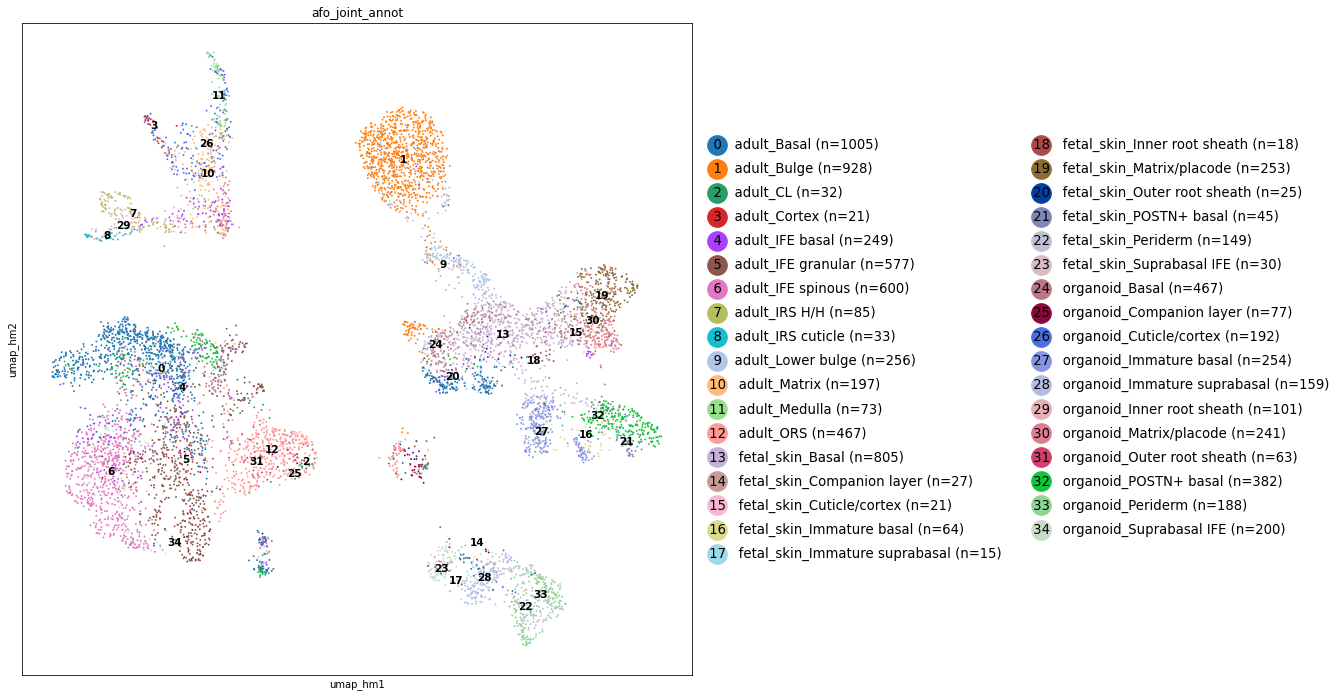

In [209]:
sk.plot_embedding(
    pooled_ad3a,
    basis="umap_hm",
    groupby="afo_joint_annot",
    annot="full",
    figsize=(12, 12),
    legend_fontsize=12,
);

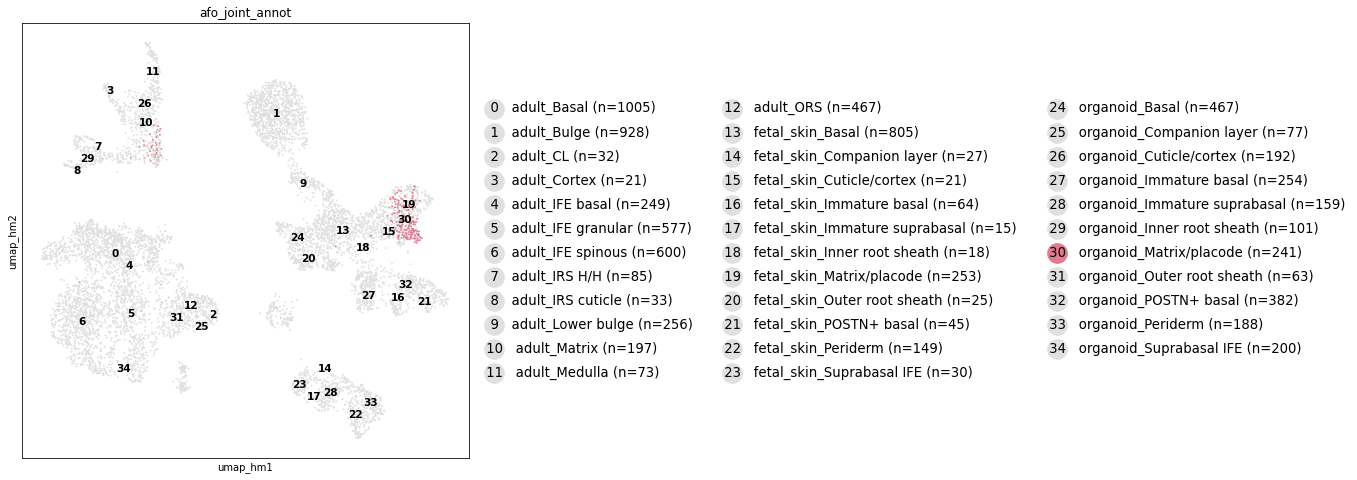

In [210]:
sk.plot_embedding(
    pooled_ad3a,
    basis="umap_hm",
    groupby="afo_joint_annot",
    annot="full",
    # highlight_group=["fetal_skin_Matrix/placode"],
    highlight_group=["organoid_Matrix/placode"],
    use_uns_colors=False,
    figsize=(8, 8),
    legend_fontsize=12,
);

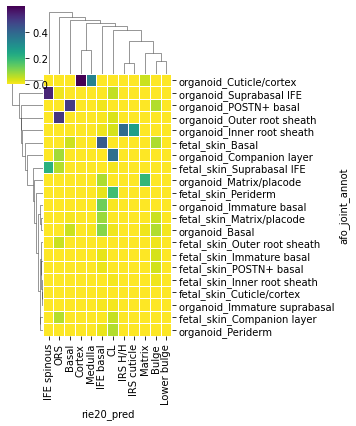

In [233]:
sk.heatmap(
    sk.cross_table(
        pooled_ad3a[
            (pooled_ad3a.obs.orig_dataset != "adult") & (pooled_ad3a.obs.rie20_pred != "Uncertain")
        ],
        "afo_joint_annot",
        "rie20_pred",
        normalise="jaccard",
    ),
    cluster=True,
    cmap="viridis_r",
    figsize=(5, 6),
)

In [30]:
sc.tl.leiden(pooled_ad2a, resolution=0.3, neighbors_key="neighbors_hm", key_added="leiden_hm_r0_3")

In [32]:
sc.tl.leiden(pooled_ad2a, resolution=0.5, neighbors_key="neighbors_hm", key_added="leiden_hm_r0_5")

In [34]:
sc.tl.leiden(pooled_ad2a, resolution=0.7, neighbors_key="neighbors_hm", key_added="leiden_hm_r0_7")

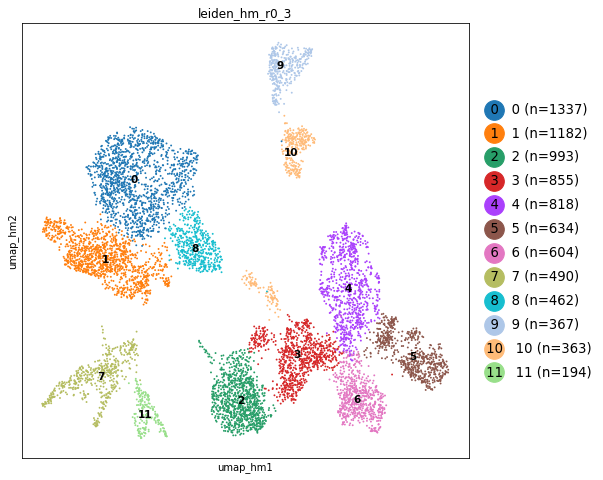

In [31]:
sk.plot_embedding(
    pooled_ad2a,
    basis="umap_hm",
    groupby="leiden_hm_r0_3",
    annot="full",
    figsize=(8, 8),
    legend_fontsize=12,
);

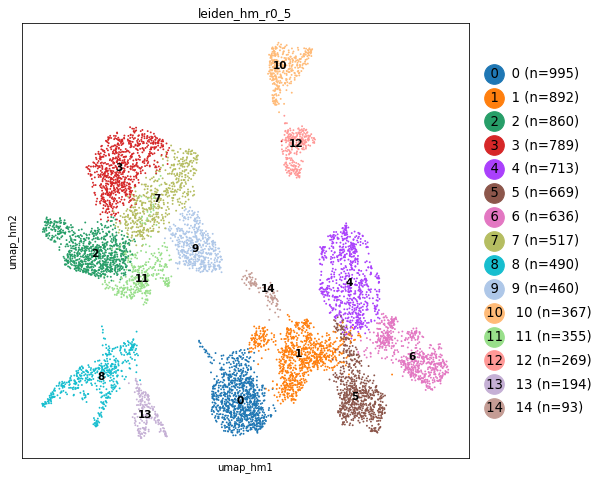

In [33]:
sk.plot_embedding(
    pooled_ad2a,
    basis="umap_hm",
    groupby="leiden_hm_r0_5",
    annot="full",
    figsize=(8, 8),
    legend_fontsize=12,
);

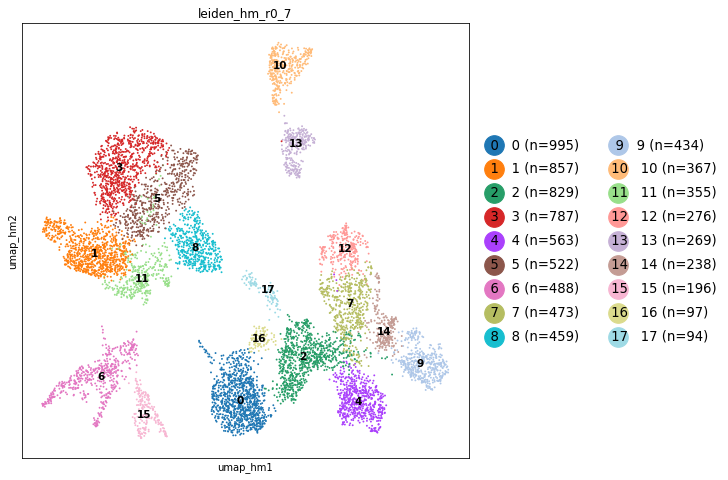

In [35]:
sk.plot_embedding(
    pooled_ad2a,
    basis="umap_hm",
    groupby="leiden_hm_r0_7",
    annot="full",
    figsize=(8, 8),
    legend_fontsize=12,
);

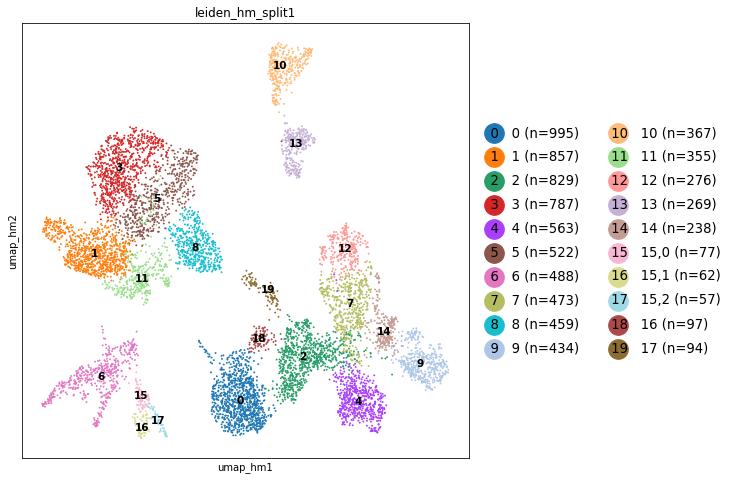

In [37]:
sc.tl.leiden(
    pooled_ad2a,
    resolution=0.2,
    restrict_to=("leiden_hm_r0_7", ["15"]),
    neighbors_key="neighbors_hm",
    key_added="leiden_hm_split1",
)
sk.plot_embedding(
    pooled_ad2a,
    basis="umap_hm",
    groupby="leiden_hm_split1",
    annot="full",
    figsize=(8, 8),
    legend_fontsize=12,
);

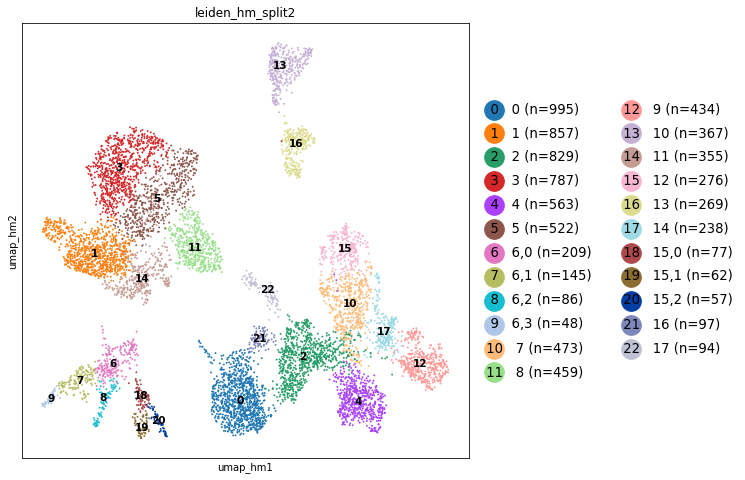

In [41]:
sc.tl.leiden(
    pooled_ad2a,
    resolution=0.2,
    restrict_to=("leiden_hm_split1", ["6"]),
    neighbors_key="neighbors_hm",
    key_added="leiden_hm_split2",
)
sk.plot_embedding(
    pooled_ad2a,
    basis="umap_hm",
    groupby="leiden_hm_split2",
    annot="full",
    figsize=(8, 8),
    legend_fontsize=12,
);

In [50]:
pooled_ad2a.obs.annot.cat.categories

Index(['adult_Basal', 'adult_Bulge', 'adult_Cortex', 'adult_IFE basal',
       'adult_IFE granular', 'adult_IFE spinous', 'adult_IRS H/H',
       'adult_IRS cuticle', 'adult_Lower bulge', 'adult_Matrix',
       'adult_Medulla', 'adult_ORS', 'fetal_org_Basal',
       'fetal_org_Companion layer', 'fetal_org_Cuticle/cortex',
       'fetal_org_Immature basal', 'fetal_org_Immature suprabasal',
       'fetal_org_Inner root sheath', 'fetal_org_Matrix/placode',
       'fetal_org_Outer root sheath', 'fetal_org_POSTN+ basal',
       'fetal_org_Periderm', 'fetal_org_Suprabasal IFE'],
      dtype='object')

In [53]:
sk.annotate(
    pooled_ad2a,
    groupby="leiden_hm_split2",
    label="afo_joint_annot",
    threshold=0.5,
)

{'adult_Bulge': ['0'],
 'adult_Basal': ['1'],
 'fetal_skin_Basal': ['2'],
 'adult_IFE spinous': ['3'],
 'organoid_Matrix/placode;fetal_skin_Matrix/placode': ['4'],
 'adult_IFE granular': ['5'],
 'organoid_Cuticle/cortex;adult_Matrix': ['6,0'],
 'adult_Matrix;adult_Medulla;organoid_Cuticle/cortex': ['6,1'],
 'organoid_Cuticle/cortex': ['6,2'],
 'organoid_Cuticle/cortex;adult_Medulla': ['6,3'],
 'adult_IFE basal;fetal_skin_Basal': ['7'],
 'adult_ORS': ['8'],
 'organoid_POSTN+ basal': ['9'],
 'fetal_skin_Periderm;organoid_Periderm': ['10'],
 'organoid_POSTN+ basal;adult_IFE granular': ['11'],
 'fetal_skin_Basal;adult_IFE basal': ['12'],
 'organoid_Suprabasal IFE;organoid_Immature suprabasal': ['13'],
 'organoid_Immature basal': ['14'],
 'organoid_Inner root sheath;adult_IRS H/H': ['15,0', '15,1'],
 'organoid_Inner root sheath;adult_IRS cuticle': ['15,2'],
 'adult_Lower bulge': ['16'],
 'organoid_Companion layer;adult_ORS': ['17']}

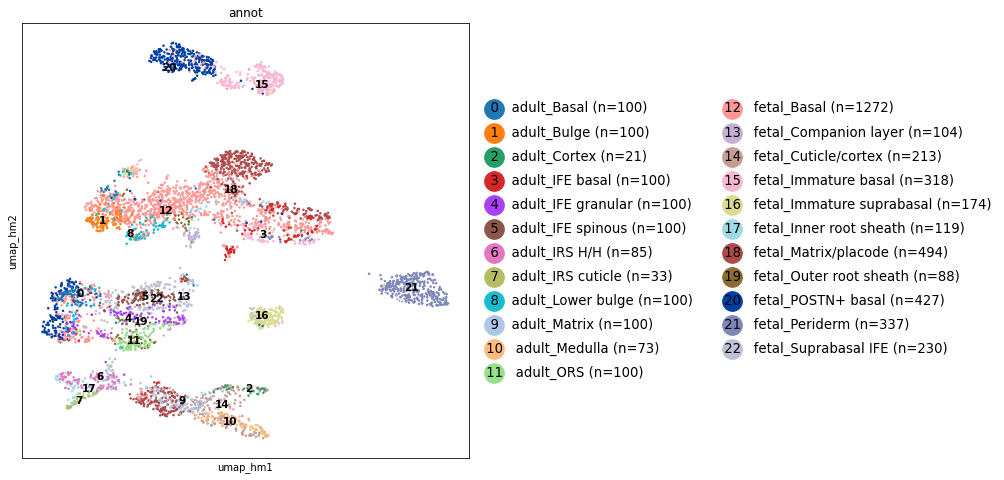

In [25]:
sk.plot_embedding(
    pooled_ad2a, basis="umap_hm", groupby="annot", annot="full", figsize=(8, 8), legend_fontsize=12
);

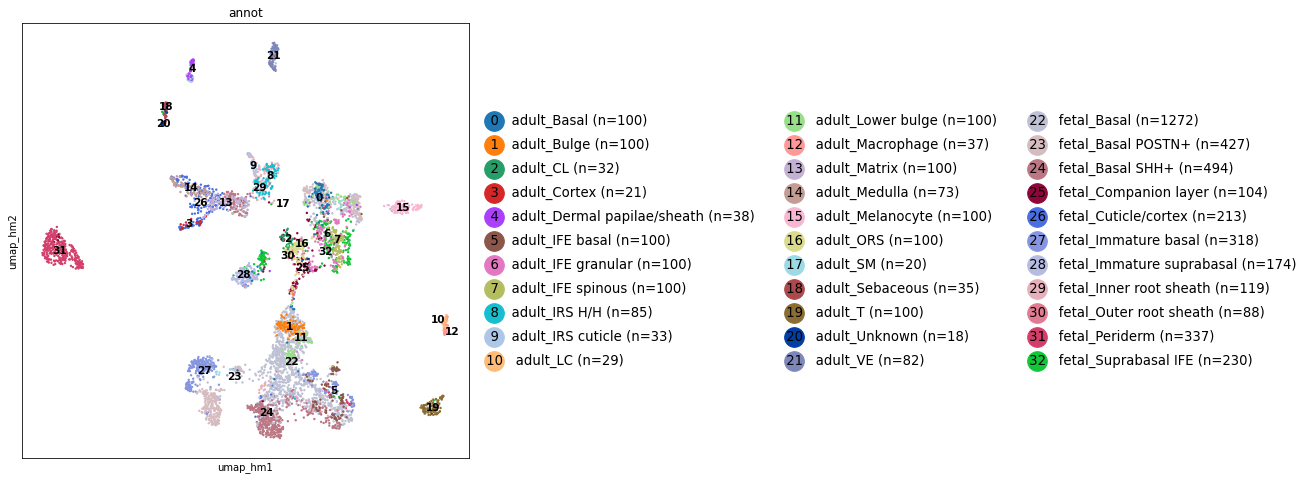

In [375]:
sk.plot_embedding(
    pooled_ad2a, basis="umap_hm", groupby="annot", annot="full", figsize=(8, 8), legend_fontsize=12
);

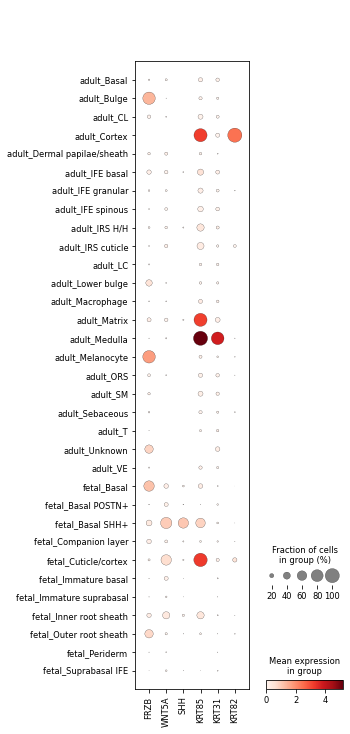

In [425]:
sk.pl.dotplot(pooled_ad2a, ["FRZB", "WNT5A", "SHH", "KRT85", "KRT31", "KRT82"], groupby="annot")

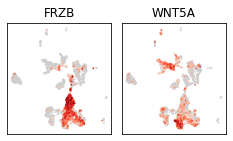

In [432]:
sk.plot_genes(
    pooled_ad2a[pooled_ad2a.obs.dataset == "fetal"],
    basis="umap_hm",
    genes=["FRZB", "WNT5A"],
    size=10,
);

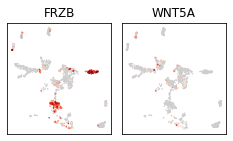

In [433]:
sk.plot_genes(
    pooled_ad2a[pooled_ad2a.obs.dataset == "adult"],
    basis="umap_hm",
    genes=["FRZB", "WNT5A"],
    size=10,
);

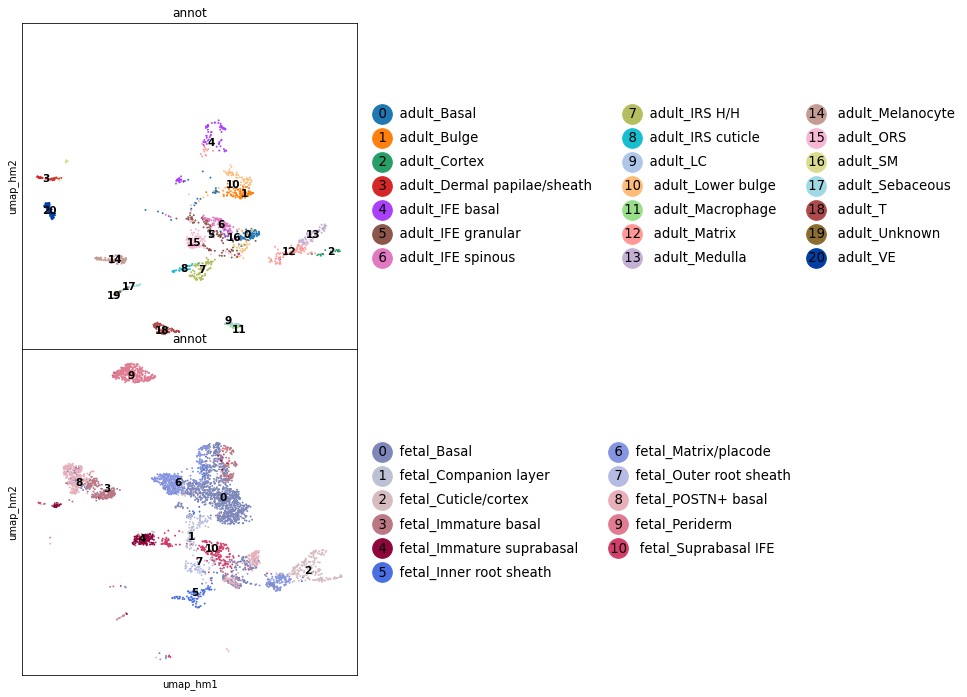

In [14]:
sk.set_figsize((6, 12))
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, gridspec_kw={"hspace": 0})

sk.plot_embedding(
    pooled_ad2a[pooled_ad2a.obs.dataset == "adult"],
    basis="umap_hm",
    groupby="annot",
    size=15,
    ax=ax[0],
    legend_fontsize=12,
)
sk.plot_embedding(
    pooled_ad2a[pooled_ad2a.obs.dataset == "fetal"],
    basis="umap_hm",
    groupby="annot",
    size=15,
    ax=ax[1],
    legend_fontsize=12,
)

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


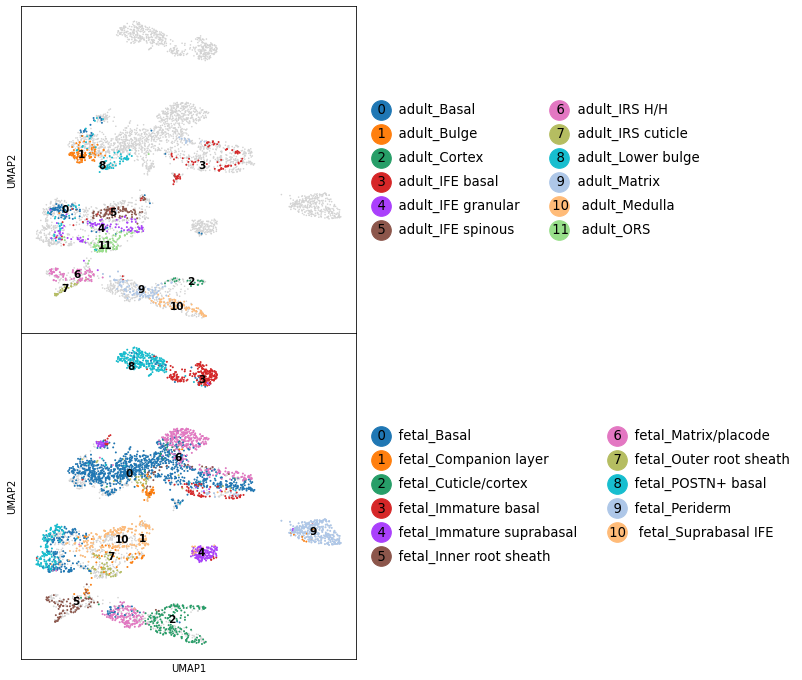

In [37]:
sk.set_figsize((6, 12))
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, gridspec_kw={"hspace": 0})

sk.clear_colors(pooled_ad2a)
sc.pl.embedding(pooled_ad2a, basis="umap_hm", ax=ax[0], legend_loc="none", show=False, size=10)
sk.plot_embedding(
    pooled_ad2a[pooled_ad2a.obs.dataset == "adult"],
    basis="umap_hm",
    groupby="annot",
    size=15,
    ax=ax[0],
    legend_fontsize=12,
    title="",
)
sk.clear_colors(pooled_ad2a)
sc.pl.embedding(pooled_ad2a, basis="umap_hm", ax=ax[1], legend_loc="none", show=False, size=10)
sk.plot_embedding(
    pooled_ad2a[pooled_ad2a.obs.dataset == "fetal"],
    basis="umap_hm",
    groupby="annot",
    size=15,
    ax=ax[1],
    legend_fontsize=12,
    title="",
)
ax[0].set_ylabel("UMAP2")
ax[1].set_ylabel("UMAP2")
ax[1].set_xlabel("UMAP1")
fig.savefig("figS2E_integrate_adult_fetal_hair_follicle.pdf", bbox_inches="tight", dpi=80)

In [39]:
!rclone copy --drive-shared-with-me figS2E_integrate_adult_fetal_hair_follicle.pdf "google:/Fetal Skin/Figures/Figs_from_Ni/"

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


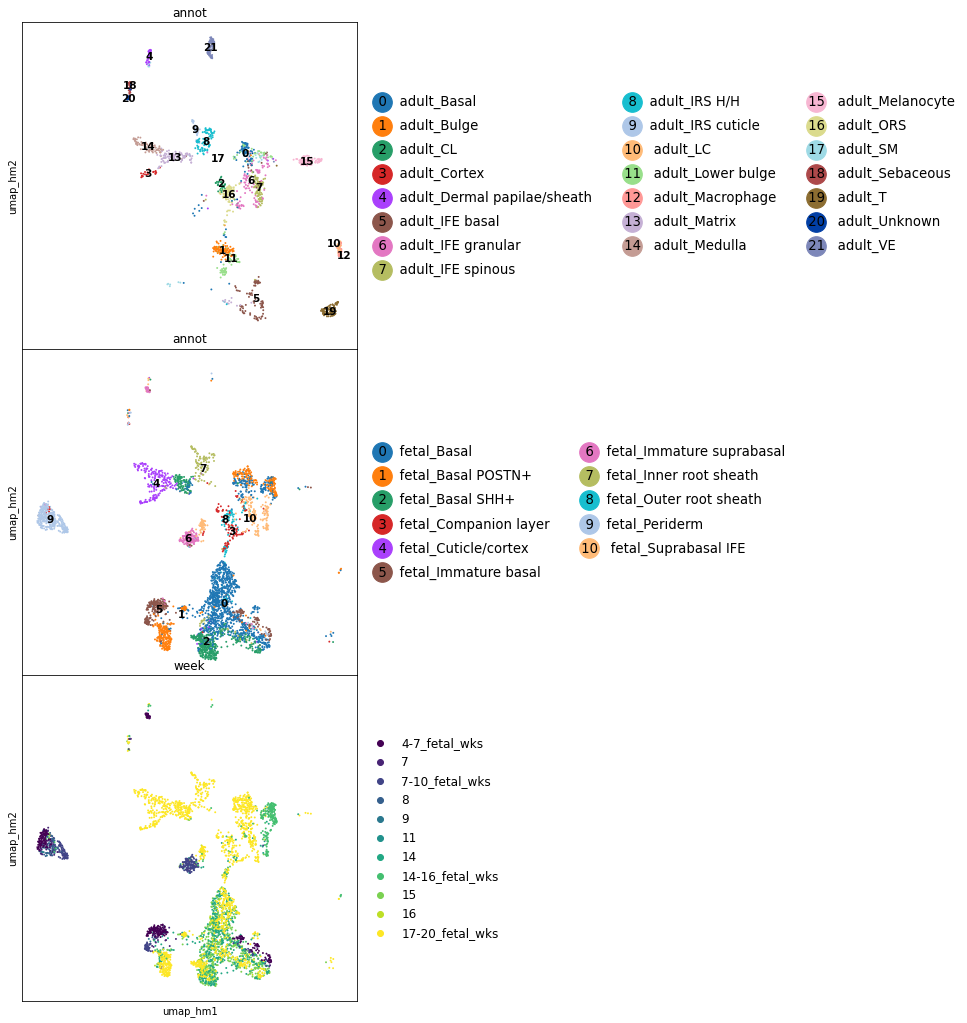

In [388]:
sk.pl.embedding(
    pooled_ad2a[pooled_ad2a.obs.dataset == "fetal"],
    basis="umap_hm",
    color="week",
    size=15,
    ax=ax[2],
    palette="viridis",
    legend_fontsize=12,
);